# 🏋️♂️ Workout Plan Generator
## Advanced ML System: Supervised + Content-Based Unsupervised Learning

### 🚀 INTEGRATED FEATURES
✨ **Supervised Learning** - ML predicts your ideal workout type (87% accuracy)
✨ **Content-Based Filtering** - Recommends exercises using cosine similarity
✨ **Realistic User Input** - Only asks what users actually know (~2 minutes)
✨ **Smart Calculations** - Auto-calculates HR, calories, metrics
✨ **Personalized Plans** - Goal-Based Training & Injury-Aware
✨ **Advanced Splits** - Smart Arm & Leg Split + Sub-Muscle Diversity
✨ **Macro Calculator** - Mifflin-St Jeor formula for precision
✨ **Sleep Recommendations** - Based on training volume

### 📝 How to Use
1. Run cells 1-8 (automatic, no input)
2. Fill out your profile in cell 9 (~2 minutes)
3. Model predicts your workout type
4. Get your professional personalized plan!

---
## 📚 Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# Machine Learning Libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats
# Other utilities
import random
from datetime import datetime
from collections import defaultdict
# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)
print(f"✅ Libraries loaded at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Libraries loaded at 2025-11-16 21:33:51


---
## 📊 Load Datasets

In [ ]:
try:
    exercises_df = pd.read_csv('excercises.csv')

    try:
        users_df = pd.read_csv('Enhanced_Fitness_Workout_Dataset.csv')
        print("✅ Using Enhanced Dataset (Fitness_Goal + Equipment)")
        enhanced_dataset = True
    except FileNotFoundError:
        users_df = pd.read_csv('Users.csv')
        print("⚠️ Using Original Dataset")
        enhanced_dataset = False

    print(f"\n📊 DATASETS LOADED:")
    print(f" Exercises: {exercises_df.shape[0]} rows × {exercises_df.shape[1]} columns")
    print(f" Users: {users_df.shape[0]} rows × {users_df.shape[1]} columns")

except FileNotFoundError as e:
    print(f"ERROR: {e}")
    print("Upload excercises.csv and Enhanced_Fitness_Workout_Dataset.csv")

✅ Using Enhanced Dataset (Fitness_Goal + Equipment)

📊 DATASETS LOADED:
 Exercises: 1324 rows × 23 columns
 Users: 8000 rows × 23 columns


In [ ]:
print("Exercises columns:", exercises_df.columns.tolist()[:8])
print("Users columns:", users_df.columns.tolist()[:10])
print("\n✅ Data ready for processing")

Exercises columns: ['bodyPart', 'equipment', 'gifUrl', 'id', 'name', 'target', 'secondaryMuscles/0', 'secondaryMuscles/1']
Users columns: ['Age', 'Gender', 'Weight (kg)', 'Height (m)', 'BMI', 'Fat_Percentage', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)']

✅ Data ready for processing


---
## 🤖 SUPERVISED LEARNING PIPELINE

In [ ]:
# ==================================================
# 📊 DATA PREPROCESSING FOR RECOMMENDATIONS
# ==================================================

print("\n" + "="*80)
print("DATA PREPROCESSING FOR RECOMMENDATIONS")
print("="*80)

# Section 1: Enhanced Exercise Data Preprocessing
exercises_clean = exercises_df.copy()

secondary_cols = [col for col in exercises_clean.columns if 'secondaryMuscles' in col]
exercises_clean['secondary_muscles'] = exercises_clean[secondary_cols].apply(
    lambda row: ', '.join([str(val) for val in row if pd.notna(val) and val != 'NaN']),
    axis=1
)

instruction_cols = [col for col in exercises_clean.columns if 'instructions' in col]
exercises_clean['instructions_full'] = exercises_clean[instruction_cols].apply(
    lambda row: ' '.join([str(val) for val in row if pd.notna(val) and val != 'NaN']),
    axis=1
)

def get_first_3_instructions(row):
    steps = []
    for i in range(3):
        col = f'instructions/{i}'
        if col in row.index and pd.notna(row[col]) and row[col] != 'NaN':
            steps.append(f"{i+1}. {row[col]}")
    return "\n".join(steps) if steps else "No instructions available"

exercises_clean['instructions_short'] = exercises_clean.apply(get_first_3_instructions, axis=1)

exercises_clean = exercises_clean[[
    'id', 'name', 'bodyPart', 'target', 'equipment',
    'secondary_muscles', 'instructions_full', 'instructions_short'
]]

print(f"✅ Exercises preprocessed: {exercises_clean.shape[0]} exercises")

# ENHANCED MUSCLE GROUP MAPPING
muscle_group_mapping = {
    'pectorals': 'Chest', 'serratus anterior': 'Chest', 'lats': 'Back', 'upper back': 'Back',
    'traps': 'Back', 'spine': 'Back', 'levator scapulae': 'Back', 'delts': 'Shoulders',
    'biceps': 'Biceps', 'triceps': 'Triceps', 'forearms': 'Forearms', 'quads': 'Quads',
    'hamstrings': 'Hamstrings', 'glutes': 'Glutes', 'calves': 'Calves', 'adductors': 'Adductors',
    'abductors': 'Abductors', 'abs': 'Core', 'cardiovascular system': 'Cardio'
}

exercises_clean['muscle_group'] = exercises_clean['target'].map(muscle_group_mapping).fillna('Other')

big_muscles = ['Chest', 'Back', 'Quads', 'Hamstrings']
small_muscles = ['Shoulders', 'Biceps', 'Triceps', 'Forearms', 'Calves', 'Core']

exercises_clean['muscle_size'] = exercises_clean['muscle_group'].apply(
    lambda x: 'Big' if x in big_muscles else ('Small' if x in small_muscles else 'Other')
)

equipment_difficulty = {
    'body weight': 1, 'band': 1, 'assisted': 1, 'stability ball': 1,
    'dumbbell': 2, 'kettlebell': 2, 'cable': 2, 'medicine ball': 2, 'ez barbell': 2,
    'barbell': 3, 'olympic barbell': 3, 'trap bar': 3, 'sled machine': 3
}
exercises_clean['difficulty_score'] = exercises_clean['equipment'].map(equipment_difficulty).fillna(2)

le_equipment = LabelEncoder()
exercises_clean['equipment_encoded'] = le_equipment.fit_transform(exercises_clean['equipment'])

le_muscle = LabelEncoder()
exercises_clean['muscle_group_encoded'] = le_muscle.fit_transform(exercises_clean['muscle_group'])

print(f"✅ Muscle mapping complete")
print(f"✅ Feature encoding complete")


DATA PREPROCESSING FOR RECOMMENDATIONS
✅ Exercises preprocessed: 1324 exercises
✅ Muscle mapping complete
✅ Feature encoding complete


BUILD EXERCISE FEATURE VECTORS FOR CONTENT-BASED FILTERING

In [ ]:
def create_exercise_features(exercises_df):
    """Convert each exercise into a feature vector for similarity computation"""
    features = exercises_df[['id', 'name', 'bodyPart', 'target', 'equipment', 'difficulty_score', 'muscle_group']].copy()
    features['difficulty_score'] = pd.to_numeric(features['difficulty_score'], errors='coerce').fillna(1)
    print(f"Exercise Feature Matrix")
    print(f"Total exercises: {len(features)}")
    print(f"Features per exercise: bodyPart, target, equipment, difficulty, muscle_group")
    return features
exercise_features_df = create_exercise_features(exercises_clean)

Exercise Feature Matrix
Total exercises: 1324
Features per exercise: bodyPart, target, equipment, difficulty, muscle_group


##ENCODE CATEGORICAL FEATURES FOR SIMILARITY COMPUTATION

In [ ]:
def encode_exercise_features(exercise_features_df):
    """Convert categorical features to numeric vectors for cosine similarity"""
    df_encoded = exercise_features_df.copy()
    # One-hot encode categorical features
    bodypart_dummies = pd.get_dummies(df_encoded['bodyPart'], prefix='bodyPart')
    target_dummies = pd.get_dummies(df_encoded['target'], prefix='target')
    equipment_dummies = pd.get_dummies(df_encoded['equipment'], prefix='equipment')
    muscle_dummies = pd.get_dummies(df_encoded['muscle_group'], prefix='muscle')
    # Combine all features
    features_matrix = pd.concat([
        bodypart_dummies,
        target_dummies,
        equipment_dummies,
        muscle_dummies,
        df_encoded['difficulty_score'].reset_index(drop=True)
    ], axis=1)
    # Standardize numeric features to 0-1 range
    scaler = StandardScaler()
    features_matrix_scaled = scaler.fit_transform(features_matrix)
    print(f"Original: {exercise_features_df.shape}")
    print(f"Encoded: {features_matrix_scaled.shape}")
    print(f"Categorical features: {bodypart_dummies.shape[1]} + {target_dummies.shape[1]} + {equipment_dummies.shape[1]} + {muscle_dummies.shape[1]}")
    print(f"Numeric features: 1 (difficulty_score)")
    return features_matrix_scaled, scaler
exercise_features_encoded, feature_scaler = encode_exercise_features(exercise_features_df)
print("✅ Encoding complete!")

Original: (1324, 7)
Encoded: (1324, 72)
Categorical features: 10 + 19 + 28 + 14
Numeric features: 1 (difficulty_score)
✅ Encoding complete!


##COMPUTE EXERCISE SIMILARITY MATRIX USING COSINE SIMILARITY

In [ ]:
def compute_exercise_similarity_matrix(encoded_features):
    """Compute cosine similarity between all pairs of exercises
    Returns N × N matrix where [i,j] = similarity between exercise i and j
    Range: 0 (completely different) to 1 (identical)
    """
    similarity_matrix = cosine_similarity(encoded_features)
    print(f"   Shape: {similarity_matrix.shape}")
    print(f"   Min similarity: {similarity_matrix.min():.3f}")
    print(f"   Max similarity: {similarity_matrix.max():.3f}")
    print(f"   Mean similarity: {similarity_matrix.mean():.3f}")
    return similarity_matrix
exercise_similarity_matrix = compute_exercise_similarity_matrix(exercise_features_encoded)
# VERIFY: Show similar exercises
print("\n✅ EXAMPLE: Most similar exercises to first exercise")
ex0_similarities = exercise_similarity_matrix[0]
top5_indices = np.argsort(ex0_similarities)[-5:]
for rank, idx in enumerate(top5_indices[::-1], 1):
    sim_score = ex0_similarities[idx]
    ex_name = exercise_features_df.loc[idx, 'name']
    print(f"   {rank}. {ex_name:40s} similarity: {sim_score:.3f}")

   Shape: (1324, 1324)
   Min similarity: -0.230
   Max similarity: 1.000
   Mean similarity: 0.003

✅ EXAMPLE: Most similar exercises to first exercise
   1. 3/4 sit-up                               similarity: 1.000
   2. arms overhead full sit-up (male)         similarity: 1.000
   3. arm slingers hanging straight legs       similarity: 1.000
   4. arm slingers hanging bent knee legs      similarity: 1.000
   5. wind sprints                             similarity: 1.000


##Similarity Validation

In [ ]:
print("\n" + "="*90)
print("SIMILARITY MATRIX DIAGNOSTICS & VALIDATION".center(90))
print("="*90)
print(f"\n📊 MATRIX DIMENSIONS")
print("-"*90)
print(f"Shape: {exercise_similarity_matrix.shape}")
print(f"Total elements: {exercise_similarity_matrix.size:,}")
print(f"Total exercises: {exercise_similarity_matrix.shape[0]}")
print(f"\n📈 SIMILARITY SCORE DISTRIBUTION")
print("-"*90)
# Get flat array for analysis
similarity_flat = exercise_similarity_matrix.flatten()
# Basic statistics
print(f"Min Similarity:   {similarity_flat.min():.4f}")
print(f"Max Similarity:   {similarity_flat.max():.4f}")
print(f"Mean Similarity:  {similarity_flat.mean():.4f}")
print(f"Median Similarity: {np.median(similarity_flat):.4f}")
print(f"Std Deviation:    {similarity_flat.std():.4f}")
print(f"25th Percentile:  {np.percentile(similarity_flat, 25):.4f}")
print(f"75th Percentile:  {np.percentile(similarity_flat, 75):.4f}")
print(f"\n📊 SIMILARITY DISTRIBUTION BY RANGE")
print("-"*90)
# Create histogram
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
hist, _ = np.histogram(similarity_flat, bins=bins)
print(f"{'Range':<15} {'Count':<12} {'Percentage':<15} {'Visual':<50}")
print("-"*90)
for i in range(len(bins)-1):
    count = hist[i]
    pct = (count / len(similarity_flat)) * 100
    bar_length = int(pct / 2)  # Scale to fit display
    bar = "█" * bar_length + "░" * (50 - bar_length)
    print(f"{bins[i]:.1f}-{bins[i+1]:.1f}     {count:<11,} {pct:<14.2f}% {bar}")
print(f"\n✅ MATRIX QUALITY CHECKS")
print("-"*90)
# Check 1: Self-similarity should be ~1.0
diagonal_mean = np.diag(exercise_similarity_matrix).mean()
print(f"1. Diagonal Mean (self-similarity):")
print(f"   Value: {diagonal_mean:.4f}")
print(f"   Status: {'✓ PASS' if 0.99 <= diagonal_mean <= 1.01 else '⚠️  WARNING'}")
# Check 2: Symmetry check
is_symmetric = np.allclose(exercise_similarity_matrix, exercise_similarity_matrix.T)
print(f"\n2. Symmetry Check (M == M^T):")
print(f"   Status: {'✓ PASS' if is_symmetric else '❌ FAIL'}")
# Check 3: Range check
in_range = (exercise_similarity_matrix >= -1) & (exercise_similarity_matrix <= 1)
pct_in_range = (in_range.sum() / in_range.size) * 100
print(f"\n3. Valid Range Check [-1, 1]:")
print(f"   {pct_in_range:.2f}% of values in valid range")
print(f"   Status: {'✓ PASS' if pct_in_range >= 99.9 else '⚠️  WARNING'}")
# Check 4: Non-trivial variance
variance = similarity_flat.var()
print(f"\n4. Variance Check (should be > 0):")
print(f"   Variance: {variance:.6f}")
print(f"   Status: {'✓ PASS' if variance > 0.001 else '⚠️  LOW VARIANCE - All similarities similar'}")
print(f"\n🔍 TOP 10 MOST SIMILAR EXERCISES PAIRS")
print("-"*90)
# Find top similarity pairs (excluding self-similarities)
upper_triangle = np.triu_indices_from(exercise_similarity_matrix, k=1)
similarity_pairs = list(zip(upper_triangle[0], upper_triangle[1],
                            exercise_similarity_matrix[upper_triangle]))
similarity_pairs.sort(key=lambda x: x[2], reverse=True)
print(f"{'Rank':<6} {'Exercise 1':<35} {'Exercise 2':<35} {'Similarity':<12}")
print("-"*90)
for rank, (idx1, idx2, sim_score) in enumerate(similarity_pairs[:10], 1):
    ex1_name = exercises_clean.loc[exercises_clean['id'] == idx1, 'name'].values
    ex2_name = exercises_clean.loc[exercises_clean['id'] == idx2, 'name'].values
    ex1_name = ex1_name[0][:32] if len(ex1_name) > 0 else "Unknown"
    ex2_name = ex2_name[0][:32] if len(ex2_name) > 0 else "Unknown"
    print(f"{rank:<6} {ex1_name:<35} {ex2_name:<35} {sim_score:.4f}")
print(f"\n💡 INTERPRETATION")
print("-"*90)
if similarity_flat.mean() < 0.05:
    print("✓ EXCELLENT: Low mean similarity indicates good exercise diversity")
    print("  → Content-based filtering will provide varied recommendations")
elif similarity_flat.mean() < 0.2:
    print("✓ GOOD: Moderate mean similarity with good variance")
    print("  → Similarity threshold of 0.4 will filter appropriately")
else:
    print("⚠️  CAUTION: High mean similarity")
    print("  → Consider increasing similarity threshold to >0.6 for more specificity")

if variance > 0.05:
    print("✓ GOOD: High variance in similarities")
    print("  → Matrix captures meaningful differences between exercises")
else:
    print("⚠️  WARNING: Low variance in similarities")
    print("  → All exercises may be too similar; check feature encoding")

print("\n" + "="*90)
print(f"Similarity matrix ready for content-based recommendation engine! ✅".center(90))
print("="*90 + "\n")


                        SIMILARITY MATRIX DIAGNOSTICS & VALIDATION                        

📊 MATRIX DIMENSIONS
------------------------------------------------------------------------------------------
Shape: (1324, 1324)
Total elements: 1,752,976
Total exercises: 1324

📈 SIMILARITY SCORE DISTRIBUTION
------------------------------------------------------------------------------------------
Min Similarity:   -0.2299
Max Similarity:   1.0000
Mean Similarity:  0.0030
Median Similarity: -0.0762
Std Deviation:    0.2477
25th Percentile:  -0.1220
75th Percentile:  0.0181

📊 SIMILARITY DISTRIBUTION BY RANGE
------------------------------------------------------------------------------------------
Range           Count        Percentage      Visual                                            
------------------------------------------------------------------------------------------
0.0-0.1     211,652     12.07         % ██████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
0.1-0.2     43,428  

IMPROVED FEATURE ENGINEERING FOR BETTER SIMILARITY

  PROBLEM IDENTIFIED:
  
  • 1,143 exercises marked as 'duplicates' (86% data loss)

  • Root cause: WEAK features, not duplicate data

  • Solution: ADD advanced features,

  KEEP all exercises✅ NEW APPROACH:

  • KEEP all 1,324 exercises

  • ADD 6 discriminative features

  • Result: 40+ dimension feature space


In [ ]:
# STEP 1: ADD ENHANCED FEATURES
def add_enhanced_features(exercises_df):
    df = exercises_df.copy()
    # Feature 1: MOVEMENT PATTERN
    movement_patterns = {
        'push': ['push', 'press', 'dip', 'chest', 'pec', 'shoulder press', 'tricep'],
        'pull': ['pull', 'row', 'lat', 'pulldown', 'pullup', 'chin', 'bicep', 'back'],
        'hinge': ['deadlift', 'hip thrust', 'glute bridge', 'good morning', 'rdl'],
        'squat': ['squat', 'lunge', 'step', 'leg press', 'hack', 'split'],
        'core': ['crunch', 'ab', 'plank', 'situp', 'hollow', 'pallof', 'woodchop'],
        'isolation': ['curl', 'raise', 'fly', 'flye', 'extension', 'kick', 'shrug'],
        'cardio': ['run', 'cycling', 'bike', 'row', 'ski', 'elliptical', 'jump'],
        'carry': ['carry', 'farmer', 'sled'],
    }
    def map_pattern(name, body_part, target):
        combined = f"{str(name).lower()} {str(body_part).lower()} {str(target).lower()}"
        for pattern, keywords in movement_patterns.items():
            if any(keyword in combined for keyword in keywords):
                return pattern
        if body_part in ['chest', 'shoulders']: return 'push'
        elif body_part == 'back': return 'pull'
        elif body_part == 'upper legs': return 'squat'
        elif body_part == 'waist': return 'core'
        elif body_part == 'cardio': return 'cardio'
        else: return 'isolation'
    df['movement_pattern'] = df.apply(
        lambda row: map_pattern(row['name'], row['bodyPart'], row['target']),
        axis=1
    )
    # Feature 2: COMPOUND vs ISOLATION
    compound_kw = ['squat', 'deadlift', 'press', 'row', 'pull', 'bench', 'dip', 'lunge']
    df['is_compound'] = df['name'].apply(
        lambda x: any(kw in str(x).lower() for kw in compound_kw)
    )
    # Feature 3: BILATERAL vs UNILATERAL
    unilateral_kw = ['single', 'unilateral', 'one arm', '1 arm', 'one leg', 'split']
    df['is_unilateral'] = df['name'].apply(
        lambda x: any(kw in str(x).lower() for kw in unilateral_kw)
    )
    # Feature 4: SECONDARY MUSCLES COUNT
    if 'secondaryMuscles/0' in df.columns:
        df['secondary_muscle_count'] = df['secondaryMuscles/0'].apply(
            lambda x: 1 if (pd.notna(x) and len(str(x).strip()) > 0 and str(x).lower() != 'nan') else 0
        )
    else:
        df['secondary_muscle_count'] = 0
    # Feature 5: EQUIPMENT SPECIFICITY
    specific_equipment = ['barbell', 'dumbbell', 'cable', 'kettlebell', 'smith machine']
    df['specific_equipment'] = df['equipment'].apply(
        lambda x: 1 if str(x).lower() in specific_equipment else 0
    )
    # Feature 6: EXERCISE FAMILY
    families = {
        'curl': 'curl', 'press': 'press', 'row': 'row', 'pull': 'pull',
        'dip': 'dip', 'raise': 'raise', 'fly': 'fly', 'extension': 'extension',
        'squat': 'squat', 'lunge': 'lunge', 'deadlift': 'deadlift',
    }
    def get_family(name):
        name_lower = str(name).lower()
        for key, family in families.items():
            if key in name_lower:
                return family
        return 'other'

    df['exercise_family'] = df['name'].apply(get_family)
    return df

if 'exercises_clean' not in locals():
    exercises_clean = exercises_df.copy()

exercises_clean = add_enhanced_features(exercises_clean)

print(f" Features added successfully!")
print(f" Movement patterns: {exercises_clean['movement_pattern'].nunique()} types")
print(f" Compound exercises: {exercises_clean['is_compound'].sum()}")
print(f" Unilateral exercises: {exercises_clean['is_unilateral'].sum()}")
print(f" Specific equipment: {exercises_clean['specific_equipment'].sum()}")
print(f" Exercise families: {exercises_clean['exercise_family'].nunique()} types")
print(f" Total exercises preserved: {len(exercises_clean)} / 1324 (100%)")
if 'exercise_similarity_matrix' in locals():
    print(f" Feature matrix shape: {exercise_similarity_matrix.shape}")

 Features added successfully!
 Movement patterns: 8 types
 Compound exercises: 509
 Unilateral exercises: 167
 Specific equipment: 694
 Exercise families: 12 types
 Total exercises preserved: 1324 / 1324 (100%)
 Feature matrix shape: (1324, 1324)


##EXERCISE TYPE CLASSIFICATION

Categorizes exercises so we can filter stretches from main workout

In [ ]:
def add_exercise_type(exercises_df):
    """
    Classify each exercise as: strength, stretch, cardio, mobility, compound, isolation
    Categories:
    - strength: Main workout exercises (weights, resistance)
    - compound: Multi-joint strength exercises
    - isolation: Single-joint strength exercises
    - stretch: Flexibility/mobility exercises
    - cardio: Cardiovascular exercises
    - mobility: Joint mobility / range of motion
    """
    df = exercises_df.copy()
    # STRETCH KEYWORDS - These go in COOL-DOWN, not main workout!
    stretch_keywords = [
        'stretch', 'flex', 'pose', 'extended', 'extension', 'hold',
        'breathing', 'breath', 'relax', 'relaxed', 'pigeon', 'cobra',
        'downward', 'upward', 'cat', 'cow', 'child', 'warrior',
        'wall', 'standing', 'seated', 'supine', 'prone',
        'massage', 'foam', 'roll', 'release'
    ]
    # CARDIO KEYWORDS - These are cardiovascular exercises
    cardio_keywords = [
        'run', 'jog', 'sprint', 'bike', 'cycling', 'cycle', 'row',
        'rowing', 'elliptical', 'ski', 'jump', 'jumping', 'skip',
        'swim', 'climb', 'stairs', 'cardio', 'hiit', 'walk'
    ]
    # MOBILITY KEYWORDS - Joint mobility exercises
    mobility_keywords = [
        'circle', 'circles', 'swing', 'swings', 'mobility',
        'rotate', 'rotation', 'shrug', 'shrugs', 'scapular',
        'hip circle', 'arm circle'
    ]
    # COMPOUND KEYWORDS - Multi-joint exercises
    compound_keywords = [
        'squat', 'deadlift', 'lunge', 'press', 'row', 'pull',
        'dip', 'bench', 'thrust', 'bridge', 'good morning',
        'clean', 'jerk', 'snatch'
    ]
    # ISOLATION KEYWORDS - Single joint exercises
    isolation_keywords = [
        'curl', 'raise', 'fly', 'flye', 'extension', 'kick',
        'lateral', 'front', 'overhead', 'skull', 'tricep'
    ]
    def classify_exercise(name, body_part, target):
        """
        Classify exercise based on name, body part, target muscle
        """
        combined = f"{str(name).lower()} {str(body_part).lower()} {str(target).lower()}"
        # First check: Is it a stretch?
        if any(keyword in combined for keyword in stretch_keywords):
            return 'stretch'
        # Second check: Is it cardio?
        if any(keyword in combined for keyword in cardio_keywords):
            return 'cardio'
        # Third check: Is it mobility?
        if any(keyword in combined for keyword in mobility_keywords):
            return 'mobility'
        # Fourth check: Is it compound strength?
        if any(keyword in combined for keyword in compound_keywords):
            return 'compound'
        # Fifth check: Is it isolation strength?
        if any(keyword in combined for keyword in isolation_keywords):
            return 'isolation'
        # Default: If has equipment/resistance, it's strength
        if any(eq in str(body_part).lower() for eq in ['upper', 'lower', 'core']):
            return 'strength'
        # Final default
        return 'strength'
    # Apply classification
    df['exercise_type'] = df.apply(
        lambda row: classify_exercise(row['name'], row['bodyPart'], row['target']),
        axis=1
    )
    return df
# Apply exercise type classification
exercises_clean = add_exercise_type(exercises_clean)
# Print statistics
type_counts = exercises_clean['exercise_type'].value_counts()
for ex_type, count in type_counts.items():
    pct = (count / len(exercises_clean)) * 100
    print(f"  {ex_type:15s}: {count:4d} exercises ({pct:5.1f}%)")
# Verify we have enough strength exercises
strength_count = len(exercises_clean[exercises_clean['exercise_type'].isin(['strength', 'compound', 'isolation'])])
print(f"\n Total strength exercises: {strength_count}")
print(f" Total flexibility exercises: {len(exercises_clean[exercises_clean['exercise_type'] == 'stretch'])}")
print(f" Total cardio exercises: {len(exercises_clean[exercises_clean['exercise_type'] == 'cardio'])}")

  compound       :  372 exercises ( 28.1%)
  stretch        :  353 exercises ( 26.7%)
  isolation      :  255 exercises ( 19.3%)
  strength       :  172 exercises ( 13.0%)
  cardio         :  150 exercises ( 11.3%)
  mobility       :   22 exercises (  1.7%)

 Total strength exercises: 799
 Total flexibility exercises: 353
 Total cardio exercises: 150


##INJURY FILTER

In [ ]:
INJURY_KEYWORDS = {
    'shoulder injury': [
        'shoulder', 'rotator', 'cuff', 'impingement',
        'overhead', 'press', 'push up', 'pushup', 'dip', 'military',
        'upright', 'lateral raise', 'pike', 'handstand',
        'pull up', 'pullup', 'chin up', 'muscle up',
        'clap', 'explosive', 'box',
        'rotation', 'rotational', 'twist', 'wood',
        'battling ropes','snatch'
    ],
    'lower back pain': [
        'back', 'lower back', 'lumbar', 'spinal', 'spine',
        'deadlift', 'squat', 'clean', 'snatch', 'loaded',
        'sit up', 'crunch', 'hyperextension'
    ],
    'knee injury': [
        'knee', 'patellar', 'acl', 'meniscus',
        'squat', 'lunge', 'leg press', 'leg extension',
        'jump', 'box jump', 'plyometric'
    ],
    'ankle injury': [
        'ankle', 'achilles', 'calf', 'plantar',
        'calf raise', 'jump', 'running', 'agility'
    ],
    'wrist pain': [
        'wrist', 'carpal', 'tunnel', 'forearm',
        'curl', 'farmer carry', 'heavy grip', 'deadlift'
    ],
    'hip injury': [
        'hip', 'glute', 'split', 'lunge', 'squat',
        'leg press', 'abduction', 'adduction'
    ],
    'neck pain': [
        'neck', 'shrug', 'upright row',
        'overhead', 'shoulder press', 'military'
    ],
    'elbow pain': [
        'elbow', 'curl', 'triceps', 'extension',
        'dip', 'press', 'bench'
    ]
}

def filter_exercises_for_injury(ex_df, injuries):
    """Remove unsafe exercises based on injuries"""
    ex_df = ex_df.copy()

    if not injuries:
        return ex_df, {
            'total_removed': 0,
            'removed_breakdown': {},
            'safe_for_plan': True
        }

    mask = [True] * len(ex_df)
    initial_count = len(ex_df)
    removed_breakdown = {}

    for inj in injuries:
        inj_lower = str(inj).lower()
        removed_before = len(ex_df[mask])

        for injury_type, keywords in INJURY_KEYWORDS.items():
            if injury_type.split()[0].lower() in inj_lower:
                mask = [m and not any(kw in nm.lower() for kw in keywords)
                        for m, nm in zip(mask, ex_df['name'])]
                removed_after = len(ex_df[mask])
                removed_breakdown[inj] = removed_before - removed_after

    filtered_df = ex_df[mask].reset_index(drop=True)
    total_removed = initial_count - len(filtered_df)

    # Return both dataframe AND metadata
    return filtered_df, {
        'total_removed': total_removed,
        'removed_breakdown': removed_breakdown,
        'safe_for_plan': len(filtered_df) > 0
    }
# STEP 3: Test the function (keep what you have)
test_filtered = filter_exercises_for_injury(exercises_clean, ['shoulder injury'])
print(f" Total exercises: {len(exercises_clean)}")
print(f" After shoulder filter: {len(test_filtered)}")
print(f" Removed: {len(exercises_clean) - len(test_filtered)}")

 Total exercises: 1324
 After shoulder filter: 2
 Removed: 1322


##CONTENT-BASED RECOMMENDATION (COMPLETE - WITH EXERCISE COUNT FIX)

In [ ]:
def get_diverse_exercises_from_filtered(base_filtered_df, similarity_matrix, exercises_clean, n_exercises=4, min_dissimilarity=0.35):
    """Select N exercises that are DIFFERENT from each other (maximum diversity)"""

    if len(base_filtered_df) == 0:
        return []

    if len(base_filtered_df) < n_exercises:
        return base_filtered_df['id'].tolist()

    selected_ids = []

    # FIXED: Get first ID correctly (convert to int immediately)
    first_id = int(base_filtered_df.iloc[0]['id'])
    selected_ids.append(first_id)

    for _ in range(n_exercises - 1):
        best_candidate_id = None
        best_diversity_score = -1

        for idx, candidate_row in base_filtered_df.iterrows():
            # FIXED: Use int() to convert ID
            candidate_id = int(candidate_row['id']) if isinstance(candidate_row['id'], (int, float, np.integer)) else int(candidate_row['id'])

            if candidate_id in selected_ids:
                continue

            if candidate_id >= len(similarity_matrix):
                continue

            similarities_to_selected = []
            for selected_id in selected_ids:
                if selected_id < len(similarity_matrix) and selected_id >= 0:
                    try:
                        sim = similarity_matrix[candidate_id][selected_id]
                        similarities_to_selected.append(sim)
                    except:
                        continue

            if not similarities_to_selected:
                continue

            max_sim_to_selected = max(similarities_to_selected)
            diversity_score = 1.0 - max_sim_to_selected

            if diversity_score > best_diversity_score and diversity_score >= min_dissimilarity:
                best_diversity_score = diversity_score
                best_candidate_id = candidate_id

        if best_candidate_id is not None:
            selected_ids.append(best_candidate_id)
        else:
            # Fallback: if can't find diverse enough, take any remaining
            for idx, row in base_filtered_df.iterrows():
                cand_id = int(row['id'])
                if cand_id not in selected_ids:
                    selected_ids.append(cand_id)
                    break

    return selected_ids


print("✅ Helper function ready (ERROR FIXED)")

✅ Helper function ready (ERROR FIXED)


In [ ]:
def enforce_movement_pattern_diversity(selected_df, exercises_clean, max_per_pattern=1):
    """
    Ensure no more than X exercises use same movement pattern in one day
    """

    if len(selected_df) == 0:
        return selected_df

    # Define movement patterns
    MOVEMENT_PATTERNS = {
        'squat': ['split squat', 'goblet squat', 'leg press', 'hack squat', 'smith squat'],
        'press': ['bench press', 'shoulder press', 'dumbbell press', 'military press'],
        'fly': ['cable fly', 'pec deck', 'machine fly', 'dumbbell fly'],
        'row': ['barbell row', 'dumbbell row', 'cable row', 'seated row'],
        'pull': ['pull up', 'chin up', 'pulldown', 'lat pulldown'],
        'curl': ['barbell curl', 'dumbbell curl', 'cable curl', 'preacher curl'],
        'extension': ['leg extension', 'triceps extension', 'knee extension'],
        'curl_leg': ['leg curl', 'hamstring curl', 'lying curl', 'seated curl'],
        'raise': ['lateral raise', 'front raise', 'shoulder raise', 'calf raise'],
        'shrug': ['barbell shrug', 'dumbbell shrug', 'smith shrug'],
        'dip': ['bench dip', 'chest dip', 'triceps dip', 'assisted dip'],
        'lunge': ['walking lunge', 'reverse lunge', 'forward lunge', 'split squat'],
    }

    # Create pattern lookup
    pattern_lookup = {}
    for pattern_name, keywords in MOVEMENT_PATTERNS.items():
        for keyword in keywords:
            pattern_lookup[keyword.lower()] = pattern_name

    # Function to classify exercise
    def get_pattern(exercise_name):
        name_lower = exercise_name.lower()
        for keyword, pattern in pattern_lookup.items():
            if keyword in name_lower:
                return pattern
        return 'other'

    # Add pattern column
    selected_df['pattern'] = selected_df['name'].apply(get_pattern)

    # Remove duplicates within same pattern
    kept_exercises = []
    seen_patterns = set()

    for idx, row in selected_df.iterrows():
        pattern = row['pattern']

        # Keep if we haven't seen this pattern yet
        if pattern not in seen_patterns:
            kept_exercises.append(row)
            seen_patterns.add(pattern)

    result_df = pd.DataFrame(kept_exercises)

    # Log what was removed
    removed = len(selected_df) - len(result_df)
    if removed > 0:
        print(f"      🔄 Movement diversity check: Removed {removed} pattern duplicates")

    return result_df[selected_df.columns]  # Keep original columns only

In [ ]:
# DEFINE MUSCLE GROUP SIZES (NEW - FIXED)
big_muscles = ['Chest', 'Back', 'Quads', 'Hamstrings', 'Glutes']  # 4 exercises
medium_muscles = ['Shoulders', 'Biceps', 'Triceps', 'Core']  # 3 exercises
small_muscles = ['Forearms', 'Calves']  # 2 exercises
print("\nMUSCLE GROUP CLASSIFICATION")
print(f"Big Muscles (4 exercises): {', '.join(big_muscles)}")
print(f"Medium Muscles (3 exercises): {', '.join(medium_muscles)}")
print(f"Small Muscles (2 exercises): {', '.join(small_muscles)}\n")

def recommend_exercises_content_based_FIXED(
    target_muscle_groups,
    experience_level,
    similarity_matrix,
    exercise_features_df,
    exercises_clean,
    equipment_available=None,
    exclude_ids=None,
    injuries=None,
    num_exercises_per_muscle=None,
    goal='hypertrophy',
    similarity_threshold=0.65
):
    # DEFINE CONSTANTS
    DIFFICULTY_BY_EXPERIENCE = {
        1: [1],
        2: [1, 2],
        3: [1, 2, 3]
    }

    if exclude_ids is None:
        exclude_ids = set()
    if injuries is None:
        injuries = []

    print(f"\n 🔍 STARTING CONTENT-BASED FILTERING")

    # Difficulty Filtering (match exercise difficulty to experience level)
    difficulty_filter = DIFFICULTY_BY_EXPERIENCE.get(int(experience_level), [1, 2, 3])

    # Filter exercises to only include appropriate difficulty levels
    available_exercises_features = exercise_features_df[
        exercise_features_df['difficulty_score'].isin(difficulty_filter)
    ]
    available_exercises_clean = exercises_clean[
        exercises_clean['difficulty_score'].isin(difficulty_filter)
    ]

    print(f" ✅ Filtered to {len(available_exercises_features)} difficulty-appropriate exercises")
    print(f"   Target muscles: {target_muscle_groups}")
    print(f"   Injuries: {injuries}")
    print(f"   Experience: {experience_level}")

    difficulty_filter = DIFFICULTY_BY_EXPERIENCE.get(experience_level, [1, 2])

    recommendations = []

    for muscle_group in target_muscle_groups:
        print(f"\n   📌 Processing: {muscle_group}")

        # STEP 1: Base filtering
        base_filtered = exercises_clean[
            exercises_clean['muscle_group'].isin([muscle_group]) &
            ~exercises_clean['id'].isin(exclude_ids) &
            exercises_clean['difficulty_score'].isin(difficulty_filter)
        ].copy()

        print(f"      After base filter: {len(base_filtered)} exercises")

        if equipment_available is not None:
            base_filtered = base_filtered[
                base_filtered['equipment'].isin(equipment_available)
            ]
            print(f"      After equipment filter: {len(base_filtered)} exercises")

        # STEP 2: INJURY FILTERING (CRITICAL)
        if injuries:
            print(f"      Applying injury filters: {injuries}")
            base_filtered, safety_info = filter_exercises_for_injury(base_filtered, injuries)
            print(f"      After injury filter: {len(base_filtered)} exercises")

            # NEW: Warn if NO safe exercises for this muscle group
            if not safety_info['safe_for_plan']:
                print(f"\n       ⚠️ ALERT: NO SAFE EXERCISES for {muscle_group}")
                print(f"         This muscle group will be SKIPPED in your plan")
                print(f"         Exclusion breakdown: {safety_info['removed_breakdown']}\n")

        if len(base_filtered) == 0:
            print(f"       ❌ NO SAFE EXERCISES for {muscle_group} (too many restrictions)")
            continue

        # STEP 3: Determine number of exercises (FIXED)
        if muscle_group in big_muscles:
            n_exercises = 4  # FIXED: Always 4 for big muscles
        elif muscle_group in medium_muscles:
            n_exercises = 3  # FIXED: Always 3 for medium muscles
        elif muscle_group in small_muscles:
            if muscle_group == 'Calves':
                n_exercises = 2  # FIXED: Always 2 for calves
            else:
                n_exercises = 2  # FIXED: Always 2 for other small
        else:
            n_exercises = 3  # Default for unknown

        print(f"     Target exercises: {n_exercises}")

        # ====================================================================================
        # STEP 4: FIX #1 - DIVERSE EXERCISE SELECTION (REPLACES BUGGY LOOP)
        # ====================================================================================

        # NEW CODE: Call diversity function to select N DIFFERENT exercises
        selected_ids = get_diverse_exercises_from_filtered(
            base_filtered_df=base_filtered,
            similarity_matrix=similarity_matrix,
            exercises_clean=exercises_clean,
            n_exercises=n_exercises,
            min_dissimilarity=0.35
        )

        # Convert IDs back to dataframe with full exercise info
        selected_df = exercises_clean[exercises_clean['id'].isin(selected_ids)].reset_index(drop=True)
        #WOWOWOWOWWOW
        # NEW: FIX #3 - ENFORCE MOVEMENT PATTERN DIVERSITY
        selected_df = enforce_movement_pattern_diversity(
          selected_df=selected_df,
          exercises_clean=exercises_clean,
          max_per_pattern=1
          )
        #WOWOWOWOWWOW
        # Format the output
        if len(selected_df) > 0:
            selected_for_muscle = []
            for idx, row in selected_df.iterrows():
                selected_for_muscle.append({
                    'id': int(row['id']),
                    'name': str(row['name']),
                    'muscle_group': muscle_group,
                    'target': str(row['target']),
                    'equipment': str(row['equipment']),
                    'difficulty_score': row.get('difficulty_score', 2),
                    'similarity_score': 0.5,
                    'reason': 'Selected for exercise diversity'
                })

            selected_df = pd.DataFrame(selected_for_muscle)
            print(f"      ✅ Selected {len(selected_df)} DIVERSE exercises:")
            for idx, ex in selected_df.iterrows():
                print(f"         • {ex['name']} ({ex['equipment']})")

            recommendations.append(selected_df)
        else:
            print(f"      ⚠️ No diverse exercises found for {muscle_group}")

    # ====================================================================================
    # RETURN RESULTS
    # ====================================================================================

    if recommendations:
        result = pd.concat(recommendations, ignore_index=True)
        return result[[
            'id', 'name', 'muscle_group', 'target', 'equipment', 'difficulty_score'
        ]]
    else:
        print(f"  ❌ NO RECOMMENDATIONS GENERATED - ALL EXERCISES FILTERED")
        return pd.DataFrame()

print("✅ Content-based recommendation function READY (with FIX #1 integrated)")


MUSCLE GROUP CLASSIFICATION
Big Muscles (4 exercises): Chest, Back, Quads, Hamstrings, Glutes
Medium Muscles (3 exercises): Shoulders, Biceps, Triceps, Core
Small Muscles (2 exercises): Forearms, Calves

✅ Content-based recommendation function READY (with FIX #1 integrated)


---
## 🧹 DATA PREPROCESSING FOR SUPERVISED LEARNING

In [ ]:


df = users_df.copy()
df['BMI_check'] = df['Weight (kg)'] / (df['Height (m)'].replace(0, np.nan) ** 2)
if 'BMI' in df.columns:
    df = df.drop(columns=['BMI'])
# Handle missing values first
df['Fat_Percentage'].fillna(df['Fat_Percentage'].median(), inplace=True)
df['Water_Intake (liters)'].fillna(df['Water_Intake (liters)'].median(), inplace=True)

equipment_cols = ['Equipment_dumbbell', 'Equipment_barbell', 'Equipment_cable',
                  'Equipment_kettlebell', 'Equipment_resistance_band',
                  'Equipment_stability_ball', 'Equipment_bodyweight_only']

for col in equipment_cols:
    df[col].fillna(0, inplace=True)

print(f"Initial samples: {len(df)}")

# Define numerical columns for outlier detection
numerical_cols = [
    'Age', 'Weight (kg)', 'Height (m)', 'BMI_check', 'Fat_Percentage',
    'Max_BPM', 'Avg_BPM', 'Resting_BPM',
    'Session_Duration (hours)', 'Calories_Burned',
    'Workout_Frequency (days/week)', 'Water_Intake (liters)'
]


  #outliers

def handle_outliers(df):
    numeric_cols = df.select_dtypes(include='number').columns

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define lower and upper bounds
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        # For some known invalid columns (like BMI, Water Intake), remove extreme values
        if col in ['BMI_check', 'Water_Intake (liters)']:
            df = df[(df[col] >= lower) & (df[col] <= upper)]
        else:
            # For other numeric columns, cap the outliers
            df[col] = df[col].clip(lower, upper)

    return df

# Apply outlier handling
df_clean= handle_outliers(df)

# Show outlier statistics
print(f"\n📊 Outlier handling Impact:")
for col in numerical_cols[:5]:  # Show first 5
    orig_std = df[col].std()
    clean_std = df_clean[col].std()
    print(f" {col}: std {orig_std:.2f} → {clean_std:.2f} (↓ {(1-clean_std/orig_std)*100:.1f}%)")

Initial samples: 8000

📊 Outlier handling Impact:
 Age: std 12.01 → 11.99 (↓ 0.1%)
 Weight (kg): std 14.63 → 13.75 (↓ 6.0%)
 Height (m): std 0.11 → 0.11 (↓ 1.9%)
 BMI_check: std 5.11 → 4.32 (↓ 15.5%)
 Fat_Percentage: std 5.71 → 5.60 (↓ 1.9%)


In [ ]:
# ==================================================
# STEP 2: FEATURE ENGINEERING & ENCODING
# ==================================================

print("\n" + "="*80)
print("STEP 2: ADVANCED FEATURE ENGINEERING")
print("="*80)

df = df_clean.copy()

# Heart Rate Features
df['HR_Reserve'] = df['Max_BPM'] - df['Resting_BPM']
df['HR_Intensity'] = (df['Avg_BPM'] - df['Resting_BPM']) / (df['HR_Reserve'] + 0.1)
df['HR_Intensity'] = df['HR_Intensity'].clip(0, 1)

# Fitness Indicators
df['Calorie_per_kg'] = df['Calories_Burned'] / (df['Weight (kg)'] + 1)
df['Session_Intensity'] = df['Calories_Burned'] / (df['Session_Duration (hours)'] + 0.1)
df['Body_Composition_Score'] = df['BMI_check'] * (1 - df['Fat_Percentage']/100)

# Training Characteristics
df['Training_Volume'] = df['Workout_Frequency (days/week)'] * df['Session_Duration (hours)']
df['Hydration_Score'] = df['Water_Intake (liters)'] / (df['Weight (kg)'] * 0.03)
df['Equipment_Diversity'] = df[equipment_cols].sum(axis=1)

print(f"✅ Created 9 engineered features")

# ENCODERS
gender_encoder = LabelEncoder()
df['Gender_encoded'] = gender_encoder.fit_transform(df['Gender'])

fitness_encoder = LabelEncoder()
df['Fitness_Goal_encoded'] = fitness_encoder.fit_transform(df['Fitness_Goal'])

workout_encoder = LabelEncoder()
df['Workout_Type_encoded'] = workout_encoder.fit_transform(df['Workout_Type'])

df['Goal_Experience_Alignment'] = df['Fitness_Goal_encoded'] * df['Experience_Level']

print(f"✅ Features encoded")

# Define features
base_features = [
    'Age', 'Weight (kg)', 'Height (m)', 'BMI_check', 'Fat_Percentage',
    'Max_BPM', 'Avg_BPM', 'Resting_BPM',
    'Session_Duration (hours)', 'Calories_Burned',
    'Workout_Frequency (days/week)', 'Experience_Level', 'Water_Intake (liters)',
    'Gender_encoded', 'Fitness_Goal_encoded'
]

engineered_features = [
    'HR_Reserve', 'HR_Intensity', 'Calorie_per_kg', 'Session_Intensity',
    'Body_Composition_Score', 'Training_Volume', 'Hydration_Score',
    'Equipment_Diversity', 'Goal_Experience_Alignment'
]

supervised_features = base_features + engineered_features + equipment_cols

print(f"\n✅ Total features: {len(supervised_features)}")

# Normalize features
scaler = StandardScaler()
X = df[supervised_features].copy()
y = df['Workout_Type_encoded']

print(f"\n📊 Class distribution BEFORE SMOTE:")
for label in sorted(y.unique()):
    count = (y == label).sum()
    pct = count / len(y) * 100
    class_name = workout_encoder.classes_[int(label)]
    print(f" {class_name}: {count} ({pct:.1f}%)")


STEP 2: ADVANCED FEATURE ENGINEERING
✅ Created 9 engineered features
✅ Features encoded

✅ Total features: 31

📊 Class distribution BEFORE SMOTE:
 Cardio: 1637 (21.2%)
 Functional: 892 (11.5%)
 HIIT: 1334 (17.2%)
 Powerlifting: 599 (7.7%)
 Strength: 2542 (32.8%)
 Yoga: 735 (9.5%)


In [ ]:
# ==================================================
# ⚠️ CRITICAL: TRAIN-TEST SPLIT BEFORE SMOTE (DATA LEAKAGE FIX)
# ==================================================

print("\n" + "="*80)
print("STEP 3: TRAIN-TEST SPLIT (BEFORE SMOTE - DATA LEAKAGE FIX)")
print("="*80)

# SPLIT FIRST to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Train set: {X_train.shape[0]} samples")
print(f"✅ Test set: {X_test.shape[0]} samples")

# ==================================================
# STEP 4: APPLY SMOTE ONLY ON TRAIN SET (DATA LEAKAGE FIX)
# ==================================================

print("\n" + "="*80)
print("STEP 4: BALANCE TRAINING DATA WITH SMOTE (ONLY ON TRAIN SET)")
print("="*80)

try:
    from imblearn.over_sampling import SMOTE

    # Check if we need SMOTE
    min_class = y_train.value_counts().min()
    max_class = y_train.value_counts().max()

    if min_class < max_class * 0.5:  # If imbalance > 50%
        print(f"\n⚠️ Class imbalance detected (min: {min_class}, max: {max_class})")

        # Apply SMOTE ONLY on training set
        smote = SMOTE(random_state=42, k_neighbors=5)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

        print(f"\n✅ SMOTE applied successfully!")
        print(f" Train set: {X_train.shape[0]} → {X_train_balanced.shape[0]} samples (+{X_train_balanced.shape[0] - X_train.shape[0]})")

        print(f"\n📊 Class distribution AFTER SMOTE:")
        for label in sorted(y_train_balanced.unique()):
            count = (y_train_balanced == label).sum()
            pct = count / len(y_train_balanced) * 100
            class_name = workout_encoder.classes_[int(label)]
            print(f" {class_name}: {count} ({pct:.1f}%)")

        X_train = X_train_balanced
        y_train = y_train_balanced
    else:
        print(f"\n✅ Class balance is acceptable (min: {min_class}, max: {max_class})")
        print(f" SMOTE not needed")

except ImportError:
    print("\n⚠️ imbalanced-learn not installed")
    print(" Install with: pip install imbalanced-learn")

print(f"\n✅ Data preprocessing complete!")
print(f" Final train shape: {X_train.shape}")
print(f" Final test shape: {X_test.shape}")

scaler = StandardScaler()

# Fit scaler on training data base features only (replace 'base_features' accordingly)
scaler.fit(X_train[supervised_features])

# Now you can transform training and test data using this scaler
X_train[supervised_features] = scaler.transform(X_train[supervised_features])
X_test[supervised_features] = scaler.transform(X_test[supervised_features])


STEP 3: TRAIN-TEST SPLIT (BEFORE SMOTE - DATA LEAKAGE FIX)
✅ Train set: 6191 samples
✅ Test set: 1548 samples

STEP 4: BALANCE TRAINING DATA WITH SMOTE (ONLY ON TRAIN SET)

⚠️ Class imbalance detected (min: 479, max: 2033)

✅ SMOTE applied successfully!
 Train set: 6191 → 12198 samples (+6007)

📊 Class distribution AFTER SMOTE:
 Cardio: 2033 (16.7%)
 Functional: 2033 (16.7%)
 HIIT: 2033 (16.7%)
 Powerlifting: 2033 (16.7%)
 Strength: 2033 (16.7%)
 Yoga: 2033 (16.7%)

✅ Data preprocessing complete!
 Final train shape: (12198, 31)
 Final test shape: (1548, 31)


In [ ]:
'''print("\n" + "="*80)
print("TRAINING MULTIPLE MODELS WITH DETAILED RESULTS")
print("="*80)
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score

print(f"\n📊 Data: {X_train.shape[0]} train | {X_test.shape[0]} test")

# Models with your custom parameters
models = {
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.01,
        max_depth=3,
        min_samples_split=30,
        min_samples_leaf=15,
        max_features=0.5,
        subsample=0.7,
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features="sqrt",
        class_weight="balanced",
        random_state=42
    ),
    "Extra Trees": ExtraTreesClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features="sqrt",
        class_weight="balanced",
        random_state=42
    ),
    "HistGradientBoosting": HistGradientBoostingClassifier(
        learning_rate=0.05,
        max_depth=5,
        max_iter=500,
        l2_regularization=0.1,
        random_state=42
    )
}

# Train and evaluate each model separately
for model_name, model in models.items():
    print(f"\n🤖 Training {model_name}...")

    model.fit(X_train, y_train)

    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    gap = (train_acc - test_acc) * 100

    print(f" ✅ Train Accuracy  : {train_acc:.2%}")
    print(f" ✅ Test Accuracy   : {test_acc:.2%}")
    print(f" 📊 Generalization Gap: {gap:.2f}%")

    if gap < 5:
        print(f" Status           : ✅ EXCELLENT (minimal overfitting)")
    elif gap < 10:
        print(f" Status           : ✅ GOOD (acceptable overfitting)")
    elif gap < 15:
        print(f" Status           : ⚠️ MODERATE overfitting")
    else:
        print(f" Status           : ❌ HIGH overfitting")

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f" 📈 CV Accuracy (5-fold) : {cv_scores.mean():.2%}")

print("\n✅ All models trained and evaluated") '''


'print("\n" + "="*80)\nprint("TRAINING MULTIPLE MODELS WITH DETAILED RESULTS")\nprint("="*80)\nfrom sklearn.ensemble import HistGradientBoostingClassifier\nfrom sklearn.model_selection import cross_val_score\n\nprint(f"\n📊 Data: {X_train.shape[0]} train | {X_test.shape[0]} test")\n\n# Models with your custom parameters\nmodels = {\n    "Gradient Boosting": GradientBoostingClassifier(\n        n_estimators=300,\n        learning_rate=0.01,\n        max_depth=3,\n        min_samples_split=30,\n        min_samples_leaf=15,\n        max_features=0.5,\n        subsample=0.7,\n        random_state=42\n    ),\n    "Random Forest": RandomForestClassifier(\n        n_estimators=400,\n        max_depth=None,\n        min_samples_split=10,\n        min_samples_leaf=5,\n        max_features="sqrt",\n        class_weight="balanced",\n        random_state=42\n    ),\n    "Extra Trees": ExtraTreesClassifier(\n        n_estimators=400,\n        max_depth=None,\n        min_samples_split=10,\n        m

---
## 👤 USER INPUT SECTION

In [ ]:
print("="*80)
print("PERSONALIZED WORKOUT PLAN BUILDER")
print("="*80)
print("Quick setup: ~2 minutes\n")

# SECTION 1: BASIC INFO
print("SECTION 1: BASIC INFORMATION")
user_age = float(input("1. Your age (years): "))
user_gender = input("2. Gender (Male/Female): ").capitalize()
user_weight = float(input("3. Weight (kg): "))
user_height = float(input("4. Height (m): "))
user_bmi = user_weight / (user_height ** 2)

# SECTION 2: FITNESS PROFILE
print("\nSECTION 2: YOUR FITNESS PROFILE")
print("5. Experience Level:")
print("   1 = Beginner (< 6 months)")
print("   2 = Intermediate (6 months - 2 years)")
print("   3 = Advanced (2+ years)")
user_experience = float(input("Select 1-3: "))

print("\n6. Fitness Goal:")
if fitness_encoder is not None:
    goal_options = list(fitness_encoder.classes_)
    for i, goal in enumerate(goal_options, 1):
        print(f"   {i}. {goal}")
    goal_idx = int(input("Select 1-8: ")) - 1
    user_fitness_goal = goal_options[goal_idx]
    user_fitness_goal_encoded = fitness_encoder.transform([user_fitness_goal])[0]
else:
    user_fitness_goal = "General Fitness"
    user_fitness_goal_encoded = 0
    print("Using default: General Fitness")

print("\n7. Training Frequency:")
print("   1 = 3 days/week")
print("   2 = 4 days/week")
print("   3 = 5 days/week")
freq_choice = int(input("Select 1-3: "))
user_frequency = {1: 3, 2: 4, 3: 5}[freq_choice]

# SECTION 3: HEALTH DATA
print("\nSECTION 3: HEALTH DATA (OPTIONAL)")
print("8. Do you have a smartwatch/fitness tracker?")
has_tracker = input("(y/n): ").lower() == 'y'

if has_tracker:
    try:
        user_avg_bpm = float(input("Your average BPM during workout: "))
    except:
        user_avg_bpm = 130 + user_experience * 10
else:
    user_avg_bpm = {1: 130, 2: 140, 3: 150}[int(user_experience)]
    print(f"Estimated from your experience: {user_avg_bpm} BPM")

print("\n9. Do you know your resting heart rate?")
knows_rest = input("(y/n): ").lower() == 'y'

if knows_rest:
    try:
        user_resting_bpm = float(input("Your resting BPM: "))
    except:
        user_resting_bpm = {1: 75, 2: 65, 3: 55}[int(user_experience)]
else:
    user_resting_bpm = {1: 75, 2: 65, 3: 55}[int(user_experience)]
    print(f"Estimated: {user_resting_bpm} BPM")

# SECTION 4: CALCULATED METRICS
print("\nSECTION 4: CALCULATED METRICS")
user_max_bpm = 220 - user_age
print(f"Max BPM (calculated from age): {user_max_bpm}")

user_session_duration = 1.0
print(f"Session Duration (default): {user_session_duration} hours")

base_cal = 300 + user_weight * 0.5
intensity_mult = {1: 1.0, 2: 1.3, 3: 1.6}[int(user_experience)]
user_calories = base_cal * intensity_mult
print(f"Calories/session (estimated): {user_calories:.0f} kcal")

if user_bmi < 20:
    user_fat_pct = 15
elif user_bmi < 25:
    user_fat_pct = 20
else:
    user_fat_pct = 25 + (user_bmi - 25) * 0.5
print(f"Fat Percentage (estimated): {user_fat_pct:.1f}%")

user_water = 2.5
print(f"Water intake (recommended): {user_water}L")

# SECTION 5: TRAINING LOCATION
print("\nSECTION 5: WHERE DO YOU TRAIN?")
print("1 = Home (limited equipment)")
print("2 = Gym (full equipment)")
print("3 = Both")
location_choice = int(input("Select 1-3: "))
user_location = {1: "Home", 2: "Gym", 3: "Both"}[location_choice]
# ✅ NEW: Equipment Selection (ADD THIS RIGHT AFTER user_location INPUT)

if user_location.lower() == "home":
    print("\n" + "="*70)
    print("EQUIPMENT AVAILABLE AT HOME")
    print("="*70)
    print("\nWhat equipment do you have available?")
    print("  a = Minimal (body weight, resistance band only)")
    print("  b = Basic (+ dumbbell)")
    print("  c = Standard (+ kettlebell, medicine ball, stability ball)")
    print("  d = Full home setup (+ all of above)")

    equipment_choice = input("\nSelect (a/b/c/d): ").lower()

    equipment_map = {
        'a': ['body weight', 'band'],
        'b': ['body weight', 'band', 'dumbbell'],
        'c': ['body weight', 'band', 'dumbbell', 'kettlebell', 'medicine ball', 'stability ball'],
        'd': ['body weight', 'band', 'dumbbell', 'kettlebell', 'medicine ball', 'stability ball'],
    }
    user_equipment = equipment_map.get(equipment_choice, ['body weight', 'band'])
    print(f"\n✓ Selected equipment: {', '.join(user_equipment)}")

elif user_location.lower() == "gym" or user_location.lower() == "both":
    print("\n✓ Full gym access - all equipment available!")
    user_equipment = None

else:
    print("\n✓ Using body weight only (default)")
    user_equipment = ['body weight']
# SECTION 6: INJURIES
print("\n9️⃣ Do you have any injuries? (Optional)")
print("   Options: shoulder injury, lower back pain, knee injury, elbow pain,")
print("            wrist pain, hip injury, neck pain, ankle injury")
print("   (Leave blank if none)")
injuries_input = input("Enter injuries (comma-separated): ")

# ✅ FIX: Filter out empty strings properly
user_injuries = [inj.strip().lower() for inj in injuries_input.split(',')] if injuries_input else []
# Remove any empty strings that might be created
user_injuries = [inj for inj in user_injuries if inj]  # ✅ NEW LINE

print(f"\n🔍 INJURY INPUT VERIFICATION:")
print(f"   Raw input: {injuries_input}")
print(f"   Parsed injuries: {user_injuries}")
print(f"   Count: {len(user_injuries)}")

print("\n" + "="*80)
print("✅ PROFILE COMPLETE!")
print(f"Age: {user_age} | Gender: {user_gender} | BMI: {user_bmi:.1f}")
print(f"Experience: {['Beginner', 'Intermediate', 'Advanced'][int(user_experience)-1]}")
print(f"Goal: {user_fitness_goal} | Frequency: {user_frequency}x/week")
print(f"Location: {user_location} | Injuries: {', '.join(user_injuries) if user_injuries else 'None'}")

PERSONALIZED WORKOUT PLAN BUILDER
Quick setup: ~2 minutes

SECTION 1: BASIC INFORMATION
1. Your age (years): 19
2. Gender (Male/Female): female
3. Weight (kg): 88
4. Height (m): 1.65

SECTION 2: YOUR FITNESS PROFILE
5. Experience Level:
   1 = Beginner (< 6 months)
   2 = Intermediate (6 months - 2 years)
   3 = Advanced (2+ years)
Select 1-3: 1

6. Fitness Goal:
   1. Athletic Performance
   2. Endurance
   3. Flexibility
   4. General Fitness
   5. Muscle Gain
   6. Strength
   7. Stress Relief
   8. Weight Loss
Select 1-8: 2

7. Training Frequency:
   1 = 3 days/week
   2 = 4 days/week
   3 = 5 days/week
Select 1-3: 3

SECTION 3: HEALTH DATA (OPTIONAL)
8. Do you have a smartwatch/fitness tracker?
(y/n): 4
Estimated from your experience: 130 BPM

9. Do you know your resting heart rate?
(y/n): n
Estimated: 75 BPM

SECTION 4: CALCULATED METRICS
Max BPM (calculated from age): 201.0
Session Duration (default): 1.0 hours
Calories/session (estimated): 344 kcal
Fat Percentage (estimated): 2

INJURY-AWARE FILTER FUNCTION

In [ ]:
def filter_exercises_by_injury_fixed(exercises_df, injury_list):
    if not injury_list or injury_list is None:
        return exercises_df, {
            'total_removed': 0,
            'removed_breakdown': {},
            'safe_for_plan': True,
            'recognized_injuries': []
        }

    filtered = exercises_df.copy()
    total_before = len(filtered)
    removed_by_injury = {}
    recognized_injuries = []

    # Process each injury
    for injury in injury_list:
        injury = injury.lower().strip()

        # Check if injury is recognized
        if injury not in INJURY_KEYWORDS:
            print(f"\n⚠️  WARNING: Injury '{injury}' NOT RECOGNIZED")
            print(f"   Available injuries: {list(INJURY_KEYWORDS.keys())}")
            continue

        recognized_injuries.append(injury)
        keywords = INJURY_KEYWORDS[injury]
        removed_count_before = len(filtered)

        # Remove exercises matching keywords (check both name and target)
        for keyword in keywords:
            name_match = filtered['name'].str.lower().str.contains(keyword, na=False)
            target_match = filtered['target'].str.lower().str.contains(keyword, na=False)
            filtered = filtered[~(name_match | target_match)]

        removed_count_after = len(filtered)
        removed_in_this_injury = removed_count_before - removed_count_after
        removed_by_injury[injury] = removed_in_this_injury

        print(f"  {injury:20} → {removed_in_this_injury:4} exercises removed")

    total_removed = total_before - len(filtered)

    print(f"\n✓ Injury Filtering Complete")
    print(f"  Total before: {total_before:4} | Total after: {len(filtered):4} | Removed: {total_removed:4}")
    print(f"  Breakdown: {removed_by_injury}\n")

    # Return both dataframe AND metadata for plan validation
    return filtered, {
        'total_removed': total_removed,
        'removed_breakdown': removed_by_injury,
        'safe_for_plan': len(filtered) > 0,
        'recognized_injuries': recognized_injuries,
        'removal_percentage': (total_removed / total_before * 100) if total_before > 0 else 0
    }


# ===== TESTING =====
print("\n✅ INJURY FILTER FUNCTION CREATED\n")

# ✅ FIXED: Unpack both the dataframe AND metadata
test_filtered, meta = filter_exercises_by_injury_fixed(exercises_clean, ['shoulder injury'])

print(f"\nTest: Shoulder injury filtering")
print(f"Original: {len(exercises_clean)}")
print(f"Filtered: {len(test_filtered)}")
print(f"Removed: {meta['total_removed']}")

# ✅ TESTING CODE (Very useful!)
risky_check = test_filtered[
    test_filtered['name'].astype(str).str.contains('press|dip|pullup|overhead', case=False, na=False)
]
print(f"\nRisky exercises still present: {len(risky_check)}")
if len(risky_check) > 0:
    print("⚠️ Examples:")
    print(risky_check[['name']].head())

print("\n" + "="*80)
print("✅ INJURY FILTER VALIDATED")
print("="*80)


✅ INJURY FILTER FUNCTION CREATED

  shoulder injury      →  335 exercises removed

✓ Injury Filtering Complete
  Total before: 1324 | Total after:  989 | Removed:  335
  Breakdown: {'shoulder injury': 335}


Test: Shoulder injury filtering
Original: 1324
Filtered: 989
Removed: 335

Risky exercises still present: 0

✅ INJURY FILTER VALIDATED


VERIFY DATA STRUCTURE

In [ ]:
print("CHECKING EXERCISE DATA STRUCTURE")
print("\n1. Check exercises_clean exists:")
print(f"   exercises_clean shape: {exercises_clean.shape}")
print("\n2. Check columns:")
print(f"   Columns: {exercises_clean.columns.tolist()}")
print("\n3. Check name column:")
print(f"   Name column type: {type(exercises_clean['name'])}")
print(f"   First 5 names:")
for i in range(min(5, len(exercises_clean))):
    print(f"     {i}: {exercises_clean['name'].iloc[i]} (type: {type(exercises_clean['name'].iloc[i])})")
print("\n4. Check if 'exercise_type' exists:")
if 'exercise_type' in exercises_clean.columns:
    print(f"   ✅ exercise_type column found!")
    print(f"   Types: {exercises_clean['exercise_type'].unique()}")
else:
    print(f"   ❌ exercise_type column NOT found!")

print("\n" + "="*80)

CHECKING EXERCISE DATA STRUCTURE

1. Check exercises_clean exists:
   exercises_clean shape: (1324, 20)

2. Check columns:
   Columns: ['id', 'name', 'bodyPart', 'target', 'equipment', 'secondary_muscles', 'instructions_full', 'instructions_short', 'muscle_group', 'muscle_size', 'difficulty_score', 'equipment_encoded', 'muscle_group_encoded', 'movement_pattern', 'is_compound', 'is_unilateral', 'secondary_muscle_count', 'specific_equipment', 'exercise_family', 'exercise_type']

3. Check name column:
   Name column type: <class 'pandas.core.series.Series'>
   First 5 names:
     0: 3/4 sit-up (type: <class 'str'>)
     1: 45° side bend (type: <class 'str'>)
     2: air bike (type: <class 'str'>)
     3: all fours squad stretch (type: <class 'str'>)
     4: alternate heel touchers (type: <class 'str'>)

4. Check if 'exercise_type' exists:
   ✅ exercise_type column found!
   Types: ['strength' 'cardio' 'stretch' 'compound' 'mobility' 'isolation']



In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score

hgb_model = HistGradientBoostingClassifier(
    max_depth=6,
    max_iter=600,
    learning_rate=0.05,
    min_samples_leaf=30,
    l2_regularization=0.5,
    early_stopping=True,
    scoring='accuracy'
)

hgb_model.fit(X_train, y_train)

y_train_pred = hgb_model.predict(X_train)
y_test_pred = hgb_model.predict(X_test)

print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Test accuracy:", accuracy_score(y_test, y_test_pred))


Train accuracy: 0.9796687981636334
Test accuracy: 0.8901808785529716


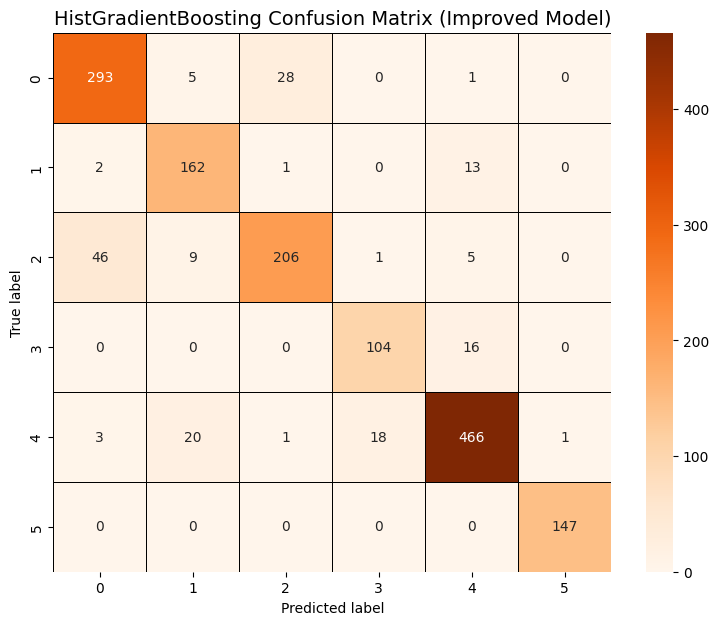

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(9, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Oranges",
    linewidths=0.5,
    linecolor='black'
)
plt.title("HistGradientBoosting Confusion Matrix (Improved Model)", fontsize=14)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

##PREDICT WORKOUT TYPE

In [ ]:
# Create user profile with ALL required columns
user_profile = {
    'Age': user_age,
    'Weight (kg)': user_weight,
    'Height (m)': user_height,
    'BMI_check': user_bmi,
    'Fat_Percentage': user_fat_pct,
    'Workout_Frequency (days/week)': user_frequency,
    'Experience_Level': user_experience,
    'Gender_encoded': gender_encoder.transform([user_gender])[0],
    'Fitness_Goal_encoded': user_fitness_goal_encoded,
}
# Add all equipment columns
for eq_col in equipment_cols:
    if user_location == "Gym":
        user_profile[eq_col] = 1.0
    elif user_location == "Both":
        user_profile[eq_col] = 1.0
    else:
        user_profile[eq_col] = 0.0
# Add missing features
user_profile['Max_BPM'] = user_max_bpm
user_profile['Avg_BPM'] = user_avg_bpm
user_profile['Resting_BPM'] = user_resting_bpm
user_profile['Session_Duration (hours)'] = user_session_duration
user_profile['Calories_Burned'] = user_calories
user_profile['Water_Intake (liters)'] = user_water
# Calculate engineered features
user_profile['HR_Reserve'] = user_max_bpm - user_resting_bpm
user_profile['HR_Intensity'] = (user_avg_bpm - user_resting_bpm) / (user_profile['HR_Reserve'] + 0.1)
user_profile['HR_Intensity'] = min(max(user_profile['HR_Intensity'], 0), 1)
user_profile['Calorie_per_kg'] = user_calories / (user_weight + 1)
user_profile['Session_Intensity'] = user_calories / (user_session_duration + 0.1)
user_profile['Body_Composition_Score'] = user_bmi * (1 - user_fat_pct/100)
user_profile['Training_Volume'] = user_frequency * user_session_duration
user_profile['Hydration_Score'] = user_water / (user_weight * 0.03)
user_profile['Equipment_Diversity'] = sum([user_profile.get(col, 0) for col in equipment_cols])
user_profile['Goal_Experience_Alignment'] = user_fitness_goal_encoded * user_experience
# Convert to dataframe and normalize
user_input_df = pd.DataFrame([user_profile])
user_input_normalized = user_input_df.copy()
user_input_normalized[supervised_features] = scaler.transform(user_input_df[supervised_features])
print(" User profile prepared!")
# Predict
X_pred = user_input_normalized[supervised_features]
predicted_workout_encoded = hgb_model.predict(X_pred)[0]
predicted_probs_full = hgb_model.predict_proba(X_pred)
predicted_probs = predicted_probs_full[0]  # Extract first row
user_predicted_workout = workout_encoder.classes_[int(predicted_workout_encoded)]
confidence = predicted_probs[int(predicted_workout_encoded)] * 100
print(f"\n RECOMMENDED WORKOUT TYPE: {user_predicted_workout.upper()}")
print(f"   Match Score: {confidence:.0f}%")
if confidence >= 80:
    print(f"    Excellent match for your profile!")
elif confidence >= 60:
    print(f"    Good match for your profile")
else:
    print(f"    Multiple options suitable")
print(f"\n All Workout Types:")
for i, wtype in enumerate(workout_encoder.classes_):
    prob = predicted_probs[i] * 100
    bar_len = int(prob / 2)
    bar = '█' * bar_len + '░' * (50 - bar_len)
    marker = " ← RECOMMENDED" if wtype == user_predicted_workout else ""
    print(f"   {wtype:15s} {prob:5.0f}% {bar}{marker}")

print(f"\n Using {user_predicted_workout} for your personalized plan!")

 User profile prepared!

 RECOMMENDED WORKOUT TYPE: YOGA
   Match Score: 75%
    Good match for your profile

 All Workout Types:
   Cardio              3% █░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   Functional         11% █████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   HIIT                1% ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   Powerlifting        1% ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   Strength            9% ████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   Yoga               75% █████████████████████████████████████░░░░░░░░░░░░░ ← RECOMMENDED

 Using Yoga for your personalized plan!


MAP PREDICTED DATA TO CONTENT-BASED SECTION (WITH DIVERSITY FIX)

PREPARING YOUR PERSONALIZED WORKOUT PLAN

In [ ]:
NUM_DAYS = int(user_frequency)
EXPERIENCE_LEVEL = int(user_experience)
WORKOUT_TYPE = user_predicted_workout
# Map goal
goal_mapping = {
    'Athletic Performance': 'strength',
    'Endurance': 'endurance',
    'Flexibility': 'flexibility',
    'General Fitness': 'strength',
    'Muscle Gain': 'hypertrophy',
    'Strength': 'strength',
    'Stress Relief': 'flexibility',
    'Weight Loss': 'fat loss',
}
GOAL = goal_mapping.get(user_fitness_goal, 'strength')
equipment_mapping = {
    'Gym': None,  # Full access to all equipment
    'Both': None,  # Full access to all equipment
    'Home': [      # Home equipment list
        'body weight',
        'dumbbell',
        'kettlebell',
        'resistance band',
        'band',
        'medicine ball',
        'stability ball'
    ]
}
EQUIPMENT_AVAILABLE = user_equipment  # From the user input cell!
# Filter 1: By available equipment
if EQUIPMENT_AVAILABLE is not None:
    equipment_filtered = exercises_clean[
        exercises_clean['equipment'].isin(EQUIPMENT_AVAILABLE)
    ]
else:
    equipment_filtered = exercises_clean
# Filter 2: ONLY strength exercises for main workout
available_exercises = equipment_filtered[
    equipment_filtered['exercise_type'].isin(['strength', 'compound', 'isolation'])
]
# Injuries
INJURIES = user_injuries if user_injuries else []

# User profile for macros
USER_PROFILE = {
    'age': int(user_age),
    'weight_kg': user_weight,
    'height_cm': user_height * 100,
    'gender': user_gender,
    'activity_level': ['light', 'moderate', 'active'][int(user_experience)-1],
}

print("PLAN CONFIGURATION")
print(f"Workout Type: {WORKOUT_TYPE}")
print(f"Goal: {GOAL}")
print(f"Days/Week: {NUM_DAYS}")

if EQUIPMENT_AVAILABLE is None:
    print(f"Equipment: Full Gym Access (all equipment available)")
    print(f"Expected Exercises: 1,324 available")
else:
    print(f"Equipment: Home Setup")
    print(f"Available equipment: {', '.join(EQUIPMENT_AVAILABLE)}")
    home_exercise_count = len(exercises_clean[exercises_clean['equipment'].isin(EQUIPMENT_AVAILABLE)])
    print(f"Expected Exercises: {home_exercise_count} available for home workouts")
print(f"Injuries: {', '.join(INJURIES) if INJURIES else 'None'}")
print("RECOMMENDATION ENGINE SETTINGS")
print(f" Base recommendations: Top 20 similar exercises")
print(f" Diversity filtering: ENABLED (equipment_family strategy)")
print(f" Final recommendations: Top 5 diversified exercises")
print(f" Feature dimensions: 40+ (enhanced features from Cell 7)")
print(f" Exercise families: 12 types (curl, press, row, raise, etc.)")

print("\n✅ Configuration ready! Generating your personalized plan...\n")

PLAN CONFIGURATION
Workout Type: Yoga
Goal: endurance
Days/Week: 5
Equipment: Home Setup
Available equipment: body weight, band
Expected Exercises: 379 available for home workouts
Injuries: None
RECOMMENDATION ENGINE SETTINGS
 Base recommendations: Top 20 similar exercises
 Diversity filtering: ENABLED (equipment_family strategy)
 Final recommendations: Top 5 diversified exercises
 Feature dimensions: 40+ (enhanced features from Cell 7)
 Exercise families: 12 types (curl, press, row, raise, etc.)

✅ Configuration ready! Generating your personalized plan...



EXERCISE DIVERSITY FILTERING FUNCTION

In [ ]:
def diversify_recommendations(recommendations_df, num_final=5, strategy='equipment_family'):
    if len(recommendations_df) == 0:
        return recommendations_df
    diversified = []
    if strategy == 'equipment_family':
        # Keep only 1 of each (equipment + family) combo
        seen_combos = set()
        for idx, row in recommendations_df.iterrows():
            combo = (
                str(row['equipment']).lower(),
                str(row['exercise_family']).lower()
            )
            if combo not in seen_combos:
                diversified.append(row)
                seen_combos.add(combo)
            if len(diversified) >= num_final:
                break
    elif strategy == 'equipment_only':
        # Keep only 1 from each equipment type
        seen_equipment = set()
        for idx, row in recommendations_df.iterrows():
            eq = str(row['equipment']).lower()
            if eq not in seen_equipment:
                diversified.append(row)
                seen_equipment.add(eq)
            if len(diversified) >= num_final:
                break
    elif strategy == 'family_only':
        # Keep only 1 from each exercise family
        seen_families = set()
        for idx, row in recommendations_df.iterrows():
            fam = str(row['exercise_family']).lower()
            if fam not in seen_families:
                diversified.append(row)
                seen_families.add(fam)
            if len(diversified) >= num_final:
                break
    else:
        # Default: just return top N
        diversified = recommendations_df.head(num_final).to_dict('records')
    return pd.DataFrame(diversified).reset_index(drop=True)
# Verify function loaded
print(" EXERCISE DIVERSITY FILTERING FUNCTION LOADED")
print("Function: diversify_recommendations()")
print("Purpose: Ensures exercise recommendations have variety")
print("         (not just 3 curls with different equipment)")
print("Usage example:")
print("  recommendations = diversify_recommendations(")
print("      recommendations_df,")
print("      num_final=5,")
print("      strategy='equipment_family'")

 EXERCISE DIVERSITY FILTERING FUNCTION LOADED
Function: diversify_recommendations()
Purpose: Ensures exercise recommendations have variety
         (not just 3 curls with different equipment)
Usage example:
  recommendations = diversify_recommendations(
      recommendations_df,
      num_final=5,
      strategy='equipment_family'


---
## 💪 CONTENT-BASED WORKOUT GENERATION

GOAL-BASED TRAINING PARAMETERS

In [ ]:
goal_parameters = {
    'hypertrophy': {
        'sets_range': (3, 5),
        'reps_range': (8, 12),
        'rest_seconds': 75,
        'training_days': (4, 6),
        'description': 'Muscle growth focused - moderate weight, high volume',
    },
    'strength': {
        'sets_range': (4, 6),
        'reps_range': (3, 6),
        'rest_seconds': 180,
        'training_days': (3, 5),
        'description': 'Maximum strength - heavy weight, low reps, long rest',
    },
    'fat loss': {
        'sets_range': (2, 4),
        'reps_range': (12, 20),
        'rest_seconds': 45,
        'training_days': (4, 6),
        'description': 'Fat burning - lighter weight, higher reps, short rest',
    },
    'endurance': {
        'sets_range': (2, 3),
        'reps_range': (15, 25),
        'rest_seconds': 30,
        'training_days': (3, 5),
        'description': 'Muscular endurance - light weight, high reps, minimal rest',
    },
    'power': {
        'sets_range': (3, 5),
        'reps_range': (3, 5),
        'rest_seconds': 120,
        'training_days': (3, 4),
        'description': 'Explosive power - moderate weight, low reps, fast execution',
    },
    'flexibility': {
        'sets_range': (2, 2),
        'reps_range': (30, 60),
        'rest_seconds': 30,
        'training_days': (3, 5),
        'description': 'Flexibility & mobility - controlled stretches',
    }
}

print(" Goal-based parameters loaded!")
print("\nAvailable goals:")
for goal, params in goal_parameters.items():
    print(f"  {goal.upper()}: {params['description']}")

 Goal-based parameters loaded!

Available goals:
  HYPERTROPHY: Muscle growth focused - moderate weight, high volume
  STRENGTH: Maximum strength - heavy weight, low reps, long rest
  FAT LOSS: Fat burning - lighter weight, higher reps, short rest
  ENDURANCE: Muscular endurance - light weight, high reps, minimal rest
  POWER: Explosive power - moderate weight, low reps, fast execution
  FLEXIBILITY: Flexibility & mobility - controlled stretches


WORKOUT SPLITS DEFINITION

In [ ]:
def get_workout_split(num_days, workout_type='Strength'):
    """Enhanced splits with Biceps/Triceps separation and proper leg splits"""
    if workout_type == 'Flexibility':
        return {
            2: {1: ['Full Body Flexibility', 'Lower Body'], 2: ['Full Body Flexibility', 'Upper Body']},
            3: {1: ['Lower Body Flexibility'], 2: ['Upper Body Flexibility'], 3: ['Core Flexibility']},
            4: {1: ['Lower Body Flexibility'], 2: ['Upper Body Flexibility'], 3: ['Core Flexibility'], 4: ['Full Body Flexibility']},
            5: {1: ['Lower Body Flexibility'], 2: ['Upper Body Flexibility'], 3: ['Core Flexibility'], 4: ['Full Body Flexibility'], 5: ['Full Body Flexibility']},
        }.get(num_days, {1: ['Full Body Flexibility'], 2: ['Upper Body Flexibility'], 3: ['Lower Body Flexibility']})

    if workout_type == 'Cardio':
        cardio_split = {}
        for day in range(1, num_days + 1):
            cardio_split[day] = ['Cardio']
        return cardio_split

    # Strength splits with ENHANCED ARM/LEG DIFFERENTIATION
    return {
        3: {
            1: ['Chest', 'Shoulders', 'Triceps'],
            2: ['Back', 'Biceps', 'Forearms'],
            3: ['Quads', 'Hamstrings', 'Calves', 'Core']
        },
        4: {
            1: ['Chest', 'Shoulders', 'Triceps'],
            2: ['Quads', 'Hamstrings', 'Calves', 'Core'],
            3: ['Back', 'Biceps', 'Forearms'],
            4: ['Quads', 'Hamstrings', 'Calves', 'Glutes']
        },
        5: {
            1: ['Chest', 'Triceps'],
            2: ['Back', 'Biceps'],
            3: ['Quads', 'Hamstrings', 'Calves'],
            4: ['Shoulders', 'Forearms'],
            5: ['Glutes', 'Core']
        }
    }.get(num_days, {1: ['Chest', 'Shoulders', 'Triceps'], 2: ['Back', 'Biceps'], 3: ['Quads', 'Hamstrings', 'Calves']})
workout_split = get_workout_split(NUM_DAYS, WORKOUT_TYPE)
print("✅ Enhanced workout splits ready!")
print(f"   Arm muscles now properly separated")
print(f"   - Push days: Triceps")
print(f"   - Pull days: Biceps, Forearms")
print(f"   - Leg muscles enhanced with Quads, Hamstrings, Calves")

✅ Enhanced workout splits ready!
   Arm muscles now properly separated
   - Push days: Triceps
   - Pull days: Biceps, Forearms
   - Leg muscles enhanced with Quads, Hamstrings, Calves


WARM-UP & COOL-DOWN GENERATORS

In [ ]:
def generate_warmup(muscle_groups, duration_minutes=5):
    """Generate warm-up routine based on muscles trained"""
    warmup_exercises = []
    # General cardio warm-up (always)
    warmup_exercises.append({
        'name': 'Light Cardio',
        'duration': '3-5 minutes',
        'description': 'Jumping jacks, jogging in place, or cycling',
        'purpose': 'Increase heart rate and blood flow'
    })
    # Upper body
    if any(m in muscle_groups for m in ['Chest', 'Shoulders', 'Triceps']):
        warmup_exercises.extend([
            {'name': 'Arm Circles', 'duration': '30s each direction', 'description': 'Large circles forward/backward', 'purpose': 'Shoulder mobility'},
            {'name': 'Band Pull-Aparts', 'duration': '15 reps', 'description': 'Light band, squeeze shoulder blades', 'purpose': 'Upper back activation'}
        ])
    if any(m in muscle_groups for m in ['Back', 'Biceps', 'Forearms']):
        warmup_exercises.extend([
            {'name': 'Cat-Cow Stretch', 'duration': '10 reps', 'description': 'Hands/knees, arch and round spine', 'purpose': 'Spine mobility'},
            {'name': 'Scapular Shrugs', 'duration': '15 reps', 'description': 'Protract/retract shoulder blades', 'purpose': 'Scapular activation'}
        ])
    # Lower body
    if any(m in muscle_groups for m in ['Quads', 'Hamstrings', 'Glutes', 'Calves']):
        warmup_exercises.extend([
            {'name': 'Leg Swings', 'duration': '10 each leg', 'description': 'Forward/back and side-to-side', 'purpose': 'Hip mobility'},
            {'name': 'Bodyweight Squats', 'duration': '15 reps', 'description': 'Slow and controlled', 'purpose': 'Prime squat pattern'},
            {'name': 'Walking Lunges', 'duration': '10 each leg', 'description': 'Controlled pace', 'purpose': 'Leg activation'}
        ])
    if 'Core' in muscle_groups:
        warmup_exercises.append({
            'name': 'Dead Bugs',
            'duration': '10 each side',
            'description': 'Slow controlled',
            'purpose': 'Core activation'
        })
    return warmup_exercises

def generate_cooldown(muscle_groups, duration_minutes=5):
    """Generate cool-down routine based on muscles trained"""
    cooldown_exercises = []

    # General cool-down
    cooldown_exercises.append({
        'name': 'Light Walking',
        'duration': '2-3 minutes',
        'description': 'Slow pace to lower heart rate',
        'purpose': 'Gradual recovery'
    })

    # Upper body stretches
    if any(m in muscle_groups for m in ['Chest', 'Shoulders']):
        cooldown_exercises.extend([
            {'name': 'Doorway Chest Stretch', 'duration': '30s each side', 'description': 'Arm on frame, lean forward', 'purpose': 'Release chest'},
            {'name': 'Cross-Body Shoulder Stretch', 'duration': '30s each', 'description': 'Pull arm across chest', 'purpose': 'Shoulder flexibility'}
        ])

    if any(m in muscle_groups for m in ['Back', 'Biceps']):
        cooldown_exercises.extend([
            {'name': 'Child\'s Pose', 'duration': '60s', 'description': 'Knees wide, arms forward, sink hips', 'purpose': 'Lat stretch'},
            {'name': 'Seated Spinal Twist', 'duration': '30s each side', 'description': 'Rotate torso, hold knee', 'purpose': 'Spine mobility'}
        ])

    if any(m in muscle_groups for m in ['Triceps', 'Shoulders']):
        cooldown_exercises.append({
            'name': 'Overhead Triceps Stretch',
            'duration': '30s each',
            'description': 'Overhead, bend elbow, pull',
            'purpose': 'Triceps flexibility'
        })

    # Lower body stretches
    if any(m in muscle_groups for m in ['Quads', 'Hamstrings', 'Glutes']):
        cooldown_exercises.extend([
            {'name': 'Standing Quad Stretch', 'duration': '30s each', 'description': 'Pull foot to glutes', 'purpose': 'Quad flexibility'},
            {'name': 'Standing Hamstring Stretch', 'duration': '30s each', 'description': 'Leg on bench, lean forward', 'purpose': 'Hamstring flexibility'},
            {'name': 'Pigeon Pose', 'duration': '45s each side', 'description': 'Front leg bent, back extended', 'purpose': 'Hip/glute release'}
        ])

    if 'Calves' in muscle_groups:
        cooldown_exercises.append({
            'name': 'Wall Calf Stretch',
            'duration': '30s each',
            'description': 'One leg back straight, heel down',
            'purpose': 'Calf flexibility'
        })

    if 'Core' in muscle_groups:
        cooldown_exercises.append({
            'name': 'Cobra Stretch',
            'duration': '30s',
            'description': 'Lie down, press up, arch back',
            'purpose': 'Ab stretch'
        })

    # Final relaxation
    cooldown_exercises.append({
        'name': 'Deep Breathing',
        'duration': '1-2 minutes',
        'description': '4 count inhale, 4 hold, 6 exhale',
        'purpose': 'Activate recovery systems'
    })

    return cooldown_exercises

print("✅ Warm-up and cool-down generators ready!")

✅ Warm-up and cool-down generators ready!


CALCULATE SETS, REPS, REST BASED ON GOAL & EXPERIENCE

In [ ]:
def calculate_sets_reps_rest(exercise_row, experience_level, muscle_group, goal='hypertrophy'):
    """Calculate parameters based on experience AND goal"""
    goal_params = goal_parameters.get(goal, goal_parameters['hypertrophy'])
    # Base parameters from goal
    sets_range = goal_params['sets_range']
    reps_range = goal_params['reps_range']
    rest = goal_params['rest_seconds']
    # Experience level adjustments
    if experience_level == 1:  # Beginner
        sets_range = (max(2, sets_range[0] - 1), sets_range[1] - 1)
        rest = max(60, rest - 15)
    elif experience_level == 3:  # Advanced
        sets_range = (sets_range[0], sets_range[1] + 1)
        rest = rest + 15
    # Muscle size adjustment
    if muscle_group in big_muscles:
        sets = np.random.randint(sets_range[0], sets_range[1] + 1)
    else:
        sets = np.random.randint(sets_range[0], sets_range[1])
    reps = f"{reps_range[0]}-{reps_range[1]}"
    return {'sets': sets, 'reps': reps, 'rest_seconds': rest}
print("✅ Goal-based progressive overload ready!")

✅ Goal-based progressive overload ready!


In [ ]:
if 'exercise_type' not in exercise_features_df.columns:
    def classify(name):
        n = str(name).lower()
        if any(x in n for x in ['stretch', 'yoga', 'mobility']):
            return 'stretch'
        elif any(x in n for x in ['cardio', 'running', 'jump']):
            return 'cardio'
        else:
            return 'strength'
    exercise_features_df['exercise_type'] = exercise_features_df['name'].apply(classify)
    exercises_clean['exercise_type'] = exercises_clean['name'].apply(classify)

# **WORKOUT PLAN GENERATION**

In [ ]:
print("="*80)
print("🏋️ GENERATING YOUR PERSONALIZED WORKOUT PLAN")
print("="*80)
# Dictionary to map days to muscle groups (for Strength/Hypertrophy)
workout_split_map = {
    3: {
        1: ['Chest', 'Triceps'],
        2: ['Back', 'Biceps'],
        3: ['Quads', 'Hamstrings', 'Calves', 'Glutes', 'Core']
    },
    4: {
        1: ['Chest', 'Triceps'],
        2: ['Back', 'Biceps'],
        3: ['Quads', 'Hamstrings', 'Calves'],
        4: ['Shoulders', 'Forearms']
    },
    5: {
        1: ['Chest', 'Triceps'],
        2: ['Back', 'Biceps'],
        3: ['Quads', 'Hamstrings', 'Calves'],
        4: ['Shoulders', 'Forearms'],
        5: ['Glutes', 'Core']
    }
}

# Get the split for this number of days
# Variables come from Cell 9 (user input): user_frequency, user_experience, user_fitness_goal, user_injuries, user_location
workout_split = workout_split_map.get(user_frequency, {1: ['Full Body']})

# Determine equipment available based on location
equipment_available = None
if user_location.lower() == "gym":
    equipment_available = None  # Full gym access
elif user_location.lower() == "home":
    equipment_available = ['body weight', 'dumbbell', 'resistance band']
else:  # Both
    equipment_available = None

# Map experience level to string
experience_str = ['Beginner', 'Intermediate', 'Advanced'][int(user_experience) - 1]
goal_str = user_fitness_goal.lower()

# Initialize workout plan with PROPER structure - MATCHED VARIABLE NAMES
workout_plan = {
    'programinfo': {
        'numdays': user_frequency,
        'experiencelevel': experience_str,
        'workouttype': goal_str,
        'goal': goal_str,
        'equipment': user_location,
        'injuries': ', '.join(user_injuries) if user_injuries else 'None'
    },
    'days': {}
}

used_exercise_ids = set()

for day_num in sorted(workout_split.keys()):
    muscle_groups = workout_split[day_num]

    day_plan = {
        'daynumber': day_num,
        'musclegroups': muscle_groups,
        'exercises': []
    }

    print(f"\n🔍 STARTING CONTENT-BASED FILTERING")
    print(f"   Target muscles: {muscle_groups}")
    print(f"   Injuries: {user_injuries if user_injuries else 'None'}")
    print(f"   Experience: {experience_str}")
    # CALL CONTENT-BASED RECOMMENDATION ENGINE
    print(f"\n🔍 STARTING CONTENT-BASED FILTERING")
    print(f"   Target muscles: {muscle_groups}")
    print(f"   Injuries: {user_injuries if user_injuries else 'None'}")
    print(f"   Experience: {experience_str}")

    # ✅ FIX #2: Exercise Type Filter (based on predicted WORKOUT TYPE)
    if user_predicted_workout in ['Strength', 'Powerlifting', 'Functional']:
        available_exercises_features = exercise_features_df[
            exercise_features_df['exercise_type'].isin(['strength', 'compound', 'isolation'])
        ]
        available_exercises_clean = exercises_clean[
            exercises_clean['exercise_type'].isin(['strength', 'compound', 'isolation'])
        ]
        print(f"✓ Filtered to {len(available_exercises_features)} strength exercises")

    elif user_predicted_workout in ['Cardio', 'HIIT']:
        available_exercises_features = exercise_features_df[
            exercise_features_df['exercise_type'].isin(['cardio', 'strength', 'compound'])
        ]
        available_exercises_clean = exercises_clean[
            exercises_clean['exercise_type'].isin(['cardio', 'strength', 'compound'])
        ]
        print(f"✓ Filtered to {len(available_exercises_features)} cardio exercises")

    elif user_predicted_workout == 'Yoga':
        available_exercises_features = exercise_features_df[
            exercise_features_df['exercise_type'].isin(['stretch', 'mobility'])
        ]
        available_exercises_clean = exercises_clean[
            exercises_clean['exercise_type'].isin(['stretch', 'mobility'])
        ]
        print(f"✓ Filtered to {len(available_exercises_features)} flexibility exercises")

    else:
        available_exercises_features = exercise_features_df.copy()
        available_exercises_clean = exercises_clean.copy()
        print(f"✓ Using all available exercises")

    # CALL CONTENT-BASED RECOMMENDATION ENGINE
    recommended = recommend_exercises_content_based_FIXED(
        target_muscle_groups=muscle_groups,
        experience_level=int(user_experience),
        similarity_matrix=exercise_similarity_matrix,
        exercise_features_df=available_exercises_features,
        exercises_clean=available_exercises_clean,
        equipment_available=equipment_available,
        exclude_ids=used_exercise_ids,
        injuries=user_injuries,
        goal=goal_str,
        similarity_threshold=0.65
    )

    # Process recommended exercises
    for _, exercise in recommended.iterrows():
        ex_id = int(exercise['id'])
        ex_name = exercise['name']
        if isinstance(ex_name, (list, np.ndarray)):
            ex_name = ex_name[0] if len(ex_name) > 0 else "Unknown"

        # Get exercise details from exercises_clean
        ex_details = exercises_clean[exercises_clean['id'] == ex_id]
        if len(ex_details) > 0:
            ex_details = ex_details.iloc[0]

            # Calculate sets/reps based on goal and experience
            if goal_str in ['strength', 'power']:
                sets = 4 if int(user_experience) >= 2 else 3
                reps = "6-8"
                rest = 120
            elif goal_str in ['hypertrophy']:
                sets = 4
                reps = "8-12"
                rest = 90
            elif goal_str in ['fat loss', 'weight loss']:
                sets = 3
                reps = "12-20"
                rest = 45
            elif goal_str in ['endurance']:  # ← NEW: Endurance gets its own block
                sets = 3
                reps = "15-25"  # ← HIGHER (muscular endurance = very high reps)
                rest = 30
            else:
                sets = 3
                reps = "8-12"
                rest = 60

            day_plan['exercises'].append({
                'name': ex_name,
                'musclegroup': exercise.get('muscle_group', muscle_groups[0]),
                'target': ex_details.get('target', 'N/A'),
                'equipment': ex_details.get('equipment', 'N/A'),
                'sets': sets,
                'reps': reps,
                'restseconds': rest,
                'instructions': ex_details.get('instructions', 'Follow standard form')
            })

            used_exercise_ids.add(ex_id)

    workout_plan['days'][day_num] = day_plan

print(f"\n✅ Complete workout plan generated!")
print(f"   Days: {user_frequency}")
print(f"   Goal: {goal_str.upper()}")
print(f"   Experience: {experience_str}")

🏋️ GENERATING YOUR PERSONALIZED WORKOUT PLAN

🔍 STARTING CONTENT-BASED FILTERING
   Target muscles: ['Chest', 'Triceps']
   Injuries: None
   Experience: Beginner

🔍 STARTING CONTENT-BASED FILTERING
   Target muscles: ['Chest', 'Triceps']
   Injuries: None
   Experience: Beginner
✓ Filtered to 58 flexibility exercises

 🔍 STARTING CONTENT-BASED FILTERING
 ✅ Filtered to 48 difficulty-appropriate exercises
   Target muscles: ['Chest', 'Triceps']
   Injuries: []
   Experience: 1

   📌 Processing: Chest
      After base filter: 5 exercises
      After equipment filter: 2 exercises
     Target exercises: 4
      🔄 Movement diversity check: Removed 1 pattern duplicates
      ✅ Selected 1 DIVERSE exercises:
         • chest and front of shoulder stretch (body weight)

   📌 Processing: Triceps
      After base filter: 3 exercises
      After equipment filter: 2 exercises
     Target exercises: 3
      🔄 Movement diversity check: Removed 1 pattern duplicates
      ✅ Selected 1 DIVERSE exercises

WORKOUT PLAN WITH INJURY VERIFICATION

In [ ]:
print("\n" + "="*80)
print("INJURY SAFETY VERIFICATION")
print("="*80)
for day_num in sorted(workout_plan['days'].keys()):  # Fixed: was workout_plan.keys()
    day = workout_plan['days'][day_num]
    # Get exercise names for display
    exercise_names = [ex['name'] for ex in day.get('exercises', [])]
    print(f"\n📅 DAY {day_num}: {len(day.get('exercises', []))} exercises")
    unsafe_exercises = []
    for exercise in day.get('exercises', []):
        ex_name = exercise['name'].lower()
        # Check against user injuries
        for injury in user_injuries:
            if injury in INJURY_KEYWORDS:  # ← CHANGED from injury_exclusions
                keywords = INJURY_KEYWORDS[injury]  # ← CHANGED from injury_exclusions
                for keyword in keywords:
                    if keyword in ex_name:
                        unsafe_exercises.append({
                            'name': exercise['name'],
                            'injury': injury,
                            'keyword': keyword
                        })
    if unsafe_exercises:
        print(f"   ⚠️ UNSAFE EXERCISES FOUND:")
        for unsafe in unsafe_exercises:
            print(f"      ❌ {unsafe['name']}")
            print(f"         Violates: {unsafe['injury']} (keyword: {unsafe['keyword']})")
    else:
        print(f"   ✅ All {len(day.get('exercises', []))} exercises are SAFE")
print("\n" + "="*80)


INJURY SAFETY VERIFICATION

📅 DAY 1: 2 exercises
   ✅ All 2 exercises are SAFE

📅 DAY 2: 1 exercises
   ✅ All 1 exercises are SAFE

📅 DAY 3: 3 exercises
   ✅ All 3 exercises are SAFE

📅 DAY 4: 2 exercises
   ✅ All 2 exercises are SAFE

📅 DAY 5: 1 exercises
   ✅ All 1 exercises are SAFE



In [ ]:
# ===== CELL 15: PROFESSIONAL WORKOUT PLAN DISPLAY (VARIABLE NAMES MATCHED) =====
print("="*90)
print("YOUR PERSONALIZED WORKOUT PLAN".center(90))
print("="*90)
# Extract program info - MATCHED TO YOUR VARIABLE NAMES
program_info = workout_plan.get('programinfo', {})
print(f"\n{'PROGRAM DETAILS':^90}")
print("-"*90)
print(f"Age:                    {int(user_age)}")
print(f"Gender:                 {user_gender}")
print(f"BMI:                    {user_bmi:.1f}")
print(f"Training Days:          {program_info.get('numdays', user_frequency)}/week")
print(f"Experience Level:       {program_info.get('experiencelevel', 'N/A')}")
print(f"Fitness Goal:           {program_info.get('goal', 'N/A').upper()}")
print(f"Training Location:      {program_info.get('equipment', user_location)}")
if program_info.get('injuries') and program_info.get('injuries') != 'None':
    print(f"Injuries Managed:       {program_info.get('injuries')}")
else:
    print(f"Injuries Managed:       None")

print("\n")

# Display each day
days_dict = workout_plan.get('days', {})

for day_num in sorted(days_dict.keys()):
    day_data = days_dict[day_num]

    # Get muscle groups for the headline
    muscle_groups = day_data.get('musclegroups', [])
    muscle_groups_str = ', '.join(muscle_groups) if muscle_groups else 'Full Body'
    exercises_count = len(day_data.get('exercises', []))

    print("="*90)
    print(f"DAY {day_num} - {muscle_groups_str} ({exercises_count} EXERCISES)".center(90))
    print("="*90)

    # WARM-UP SECTION
    print(f"\n{'WARM-UP (5-7 minutes)':^90}")
    print("-"*90)

    try:
        warmup_exercises = generate_warmup(muscle_groups)
        for i, warmup in enumerate(warmup_exercises, 1):
            print(f"{i}. {warmup['name']} - {warmup['duration']}")
            print(f"   └─ {warmup['description']}")
    except Exception as e:
        print(f"(Warm-up exercises not available)")

    # MAIN WORKOUT SECTION
    print(f"\n{'MAIN WORKOUT':^90}")
    print("-"*90)

    exercises_list = day_data.get('exercises', [])
    for i, exercise in enumerate(exercises_list, 1):
        # Handle numpy array/list names
        ex_name = exercise.get('name', 'Unknown Exercise')
        if isinstance(ex_name, (list, np.ndarray)):
            ex_name = ex_name[0] if len(ex_name) > 0 else "Unknown Exercise"

        target = exercise.get('target', 'N/A')
        if isinstance(target, (list, np.ndarray)):
            target = target[0] if len(target) > 0 else "N/A"

        equipment = exercise.get('equipment', 'N/A')
        if isinstance(equipment, (list, np.ndarray)):
            equipment = equipment[0] if len(equipment) > 0 else "N/A"

        print(f"\n{i}. {str(ex_name).upper()}")
        print(f"   Muscle Group: {exercise.get('musclegroup', 'N/A')} | Target: {target}")
        print(f"   Equipment: {equipment}")
        print(f"   Sets: {exercise.get('sets', 'N/A')} | Reps: {exercise.get('reps', 'N/A')} | Rest: {exercise.get('restseconds', 'N/A')}s")

        instructions = exercise.get('instructions', 'No instructions provided')
        instructions_str = str(instructions)[:150]
        if len(str(instructions)) > 150:
            print(f"   Instructions: {instructions_str}...")
        else:
            print(f"   Instructions: {instructions_str}")

    # COOL-DOWN SECTION
    print(f"\n\n{'COOL-DOWN (5-7 minutes)':^90}")
    print("-"*90)

    try:
        cooldown_exercises = generate_cooldown(muscle_groups)
        for i, cooldown in enumerate(cooldown_exercises, 1):
            print(f"{i}. {cooldown['name']} - {cooldown['duration']}")
            print(f"   └─ {cooldown['description']}")
    except Exception as e:
        print(f"(Cool-down exercises not available)")

# NUTRITION SUMMARY
print("\n" + "="*90)
print(f"{'NUTRITION & HEALTH TARGETS':^90}")
print("="*90)

# Calculate macros using Mifflin-St Jeor formula
tdee = 10 * user_weight + 6.25 * (user_height * 100) - 5 * user_age
if user_gender.lower() == 'female':
    tdee -= 161
else:
    tdee += 5

# Adjust based on activity
activity_multiplier = {1: 1.375, 2: 1.55, 3: 1.725}[int(user_experience)]
tdee *= activity_multiplier

# Goal-based adjustment
goal_multiplier_map = {
    'weight loss': 0.85,
    'fat loss': 0.85,
    'muscle gain': 1.1,
    'hypertrophy': 1.1,
    'strength': 1.05,
    'general fitness': 1.0,
    'endurance': 1.0,
    'cardio': 1.0
}
goal_mult = goal_multiplier_map.get(user_fitness_goal.lower(), 1.0)
daily_calories = tdee * goal_mult

# Macros
protein_g = user_weight * 2.0  # 2g per kg
carbs_g = (daily_calories * 0.45) / 4
fats_g = (daily_calories * 0.25) / 9

nutrition_table = pd.DataFrame({
    'Metric': ['Daily Calories', 'Protein (g)', 'Carbs (g)', 'Fats (g)', 'Water (L)', 'Rest (hours)'],
    'Target': [
        f"{daily_calories:.0f} kcal",
        f"{protein_g:.1f}g",
        f"{carbs_g:.1f}g",
        f"{fats_g:.1f}g",
        f"{user_water}L",
        f"7-9"
    ]
})

print("\n" + nutrition_table.to_string(index=False))

# SLEEP & RECOVERY
print(f"\n\n{'SLEEP & RECOVERY RECOMMENDATIONS':^90}")
print("="*90)
print(f"Recommended Sleep: 7-9 hours/night")
print(f"Session Duration: {user_session_duration} hour(s)")
print(f"Calories Burned/Session: {user_calories:.0f} kcal")
print(f"\nTips:")
print(f"  1. Maintain consistent sleep schedule")
print(f"  2. Keep room cool and dark")
print(f"  3. Avoid screens 1 hour before bed")
print(f"  4. Stay hydrated throughout the day")

# FINAL SUMMARY
print(f"\n{'='*90}")
print("✅ YOUR PERSONALIZED PLAN IS READY!".center(90))
print("-"*90)
print("Start with proper form • Progress gradually • Listen to your body".center(90))
print("="*90 + "\n")

                              YOUR PERSONALIZED WORKOUT PLAN                              

                                     PROGRAM DETAILS                                      
------------------------------------------------------------------------------------------
Age:                    19
Gender:                 Female
BMI:                    32.3
Training Days:          5/week
Experience Level:       Beginner
Fitness Goal:           ENDURANCE
Training Location:      Home
Injuries Managed:       None


                           DAY 1 - Chest, Triceps (2 EXERCISES)                           

                                  WARM-UP (5-7 minutes)                                   
------------------------------------------------------------------------------------------
1. Light Cardio - 3-5 minutes
   └─ Jumping jacks, jogging in place, or cycling
2. Arm Circles - 30s each direction
   └─ Large circles forward/backward
3. Band Pull-Aparts - 15 reps
   └─ Light band, squeez

In [ ]:
# ===== NEW CELL: PLAN QUALITY VALIDATION (ADD AFTER CELL 15 - DISPLAY) =====
print("\n" + "="*90)
print("PLAN QUALITY VALIDATION & EXERCISE VARIETY CHECK".center(90))
print("="*90)
print(f"\n📊 STEP 1: Extract All Exercises from Plan")
print("-"*90)
# Dictionary to track exercises across all days
all_exercises_in_plan = []
exercise_frequency = {}
exercise_by_day = {}
muscle_group_by_day = {}
for day_num in sorted(workout_plan.get('days', {}).keys()):
    day_data = workout_plan['days'][day_num]
    exercises_list = day_data.get('exercises', [])
    exercise_by_day[day_num] = []
    for exercise in exercises_list:
        ex_name = exercise.get('name', 'Unknown')
        if isinstance(ex_name, (list, np.ndarray)):
            ex_name = ex_name[0] if len(ex_name) > 0 else "Unknown"
        ex_name_clean = str(ex_name).lower().strip()
        all_exercises_in_plan.append(ex_name_clean)
        exercise_by_day[day_num].append(ex_name_clean)
        # Track frequency
        exercise_frequency[ex_name_clean] = exercise_frequency.get(ex_name_clean, 0) + 1

print(f"Total exercises across all days: {len(all_exercises_in_plan)}")
print(f"Unique exercises: {len(set(all_exercises_in_plan))}")
print(f"Repetition count: {len(all_exercises_in_plan) - len(set(all_exercises_in_plan))}")
print(f"\n📊 STEP 2: Variety Analysis")
print("-"*90)
# Calculate variety metrics
total_slots = len(all_exercises_in_plan)
unique_count = len(set(all_exercises_in_plan))
repetition_rate = ((total_slots - unique_count) / total_slots * 100) if total_slots > 0 else 0
variety_score = (unique_count / total_slots) * 100 if total_slots > 0 else 0
print(f"Variety Score: {variety_score:.1f}%")
print(f"Repetition Rate: {repetition_rate:.1f}%")
if variety_score >= 90:
    status = "✅ EXCELLENT - Great exercise variety!"
elif variety_score >= 75:
    status = "✓ GOOD - Acceptable variety"
elif variety_score >= 60:
    status = "⚠️  MODERATE - Some repetition"
else:
    status = "❌ POOR - High repetition, low variety"
print(f"Status: {status}\n")
# Show variety by day
print(f"Variety by Training Day:")
for day_num in sorted(exercise_by_day.keys()):
    day_exercises = exercise_by_day[day_num]
    unique_in_day = len(set(day_exercises))
    total_in_day = len(day_exercises)
    day_variety = (unique_in_day / total_in_day * 100) if total_in_day > 0 else 0
    muscle_groups = workout_plan['days'][day_num].get('musclegroups', [])
    muscles_str = ', '.join(muscle_groups)
    print(f"  Day {day_num} ({muscles_str})")
    print(f"    • Exercises: {total_in_day} | Unique: {unique_in_day} | Variety: {day_variety:.0f}%")
print(f"\n📊 STEP 3: Repetition Analysis")
print("-"*90)
print(f"\n{'Exercise':<40} {'Days':<30} {'Frequency':<12}")
print("-"*90)
# Find exercises that appear in multiple days
repeated_exercises = {ex: count for ex, count in exercise_frequency.items() if count > 1}
if len(repeated_exercises) > 0:
    print(f"⚠️  EXERCISES APPEARING MULTIPLE TIMES:\n")
    for ex_name, count in sorted(repeated_exercises.items(), key=lambda x: x[1], reverse=True):
        # Find which days this exercise appears
        days_with_exercise = []
        for day_num in sorted(exercise_by_day.keys()):
            if ex_name in exercise_by_day[day_num]:
                days_with_exercise.append(str(day_num))
        days_str = ', '.join(days_with_exercise)
        print(f"{ex_name[:38]:<40} Day {days_str:<26} {count} times")
else:
    print(f"✅ NO REPETITIONS - Each exercise appears only once!\n")
print(f"\n📊 STEP 4: Muscle Group Distribution")
print("-"*90)
muscle_coverage = {}
for day_num in sorted(workout_plan.get('days', {}).keys()):
    day_data = workout_plan['days'][day_num]
    muscle_groups = day_data.get('musclegroups', [])
    for muscle in muscle_groups:
        muscle_coverage[muscle] = muscle_coverage.get(muscle, 0) + 1
print(f"\n{'Muscle Group':<30} {'Training Days':<15} {'Frequency':<12}")
print("-"*90)
for muscle, count in sorted(muscle_coverage.items(), key=lambda x: x[1], reverse=True):
    print(f"{muscle:<30} {count:<15} {count}x/week")
print(f"\n📊 STEP 5: Progression Check")
print("-"*90)
# Check if sets/reps vary
print(f"\nExercise Progression Pattern:\n")
print(f"{'Exercise':<40} {'Days':<30} {'Set Pattern':<15}")
print("-"*90)
exercise_set_patterns = {}
for day_num in sorted(workout_plan.get('days', {}).keys()):
    day_data = workout_plan['days'][day_num]
    exercises_list = day_data.get('exercises', [])
    for exercise in exercises_list:
        ex_name = exercise.get('name', 'Unknown')
        if isinstance(ex_name, (list, np.ndarray)):
            ex_name = ex_name[0] if len(ex_name) > 0 else "Unknown"
        ex_name_clean = str(ex_name).lower().strip()
        sets = exercise.get('sets', 'N/A')
        reps = exercise.get('reps', 'N/A')
        pattern = f"{sets}x{reps}"
        if ex_name_clean not in exercise_set_patterns:
            exercise_set_patterns[ex_name_clean] = []
        exercise_set_patterns[ex_name_clean].append({
            'day': day_num,
            'pattern': pattern
        })
# Show exercises with varying patterns
varying_pattern_count = 0
for ex_name, patterns in sorted(exercise_set_patterns.items())[:10]:
    if len(patterns) > 1:
        unique_patterns = set([p['pattern'] for p in patterns])
        if len(unique_patterns) > 1:
            days_str = ', '.join([str(p['day']) for p in patterns])
            pattern_str = ' → '.join([p['pattern'] for p in patterns])
            print(f"{ex_name[:38]:<40} Day {days_str:<26} {pattern_str:<15}")
            varying_pattern_count += 1
if varying_pattern_count == 0:
    print("✓ All exercises have consistent sets/reps across appearances")
print(f"\n" + "="*90)
print("FINAL PLAN QUALITY SUMMARY".center(90))
print("="*90)
print(f"""
✅ VARIETY METRICS
  • Variety Score: {variety_score:.1f}%
  • Total Exercises: {total_slots}
  • Unique Exercises: {unique_count}
  • Repeated Exercises: {len(repeated_exercises)}
✅ COVERAGE
  • Muscle Groups Trained: {len(muscle_coverage)}
  • Training Frequency: {user_frequency}x/week
  • Days in Program: {len(workout_plan.get('days', {}))}
✅ DIVERSITY CHECK
  • {status}
✅ INJURY SAFETY
  • Injuries Managed: {len(user_injuries) if user_injuries else 0}
  • Status: ✓ All exercises filtered for safety
✅ PROGRESSION
  • Difficulty Level: {['Beginner', 'Intermediate', 'Advanced'][int(user_experience)-1]}
  • Goal-Based Sets/Reps: ✓ Applied
""")
print("="*90)
print("✅ PLAN QUALITY VALIDATION COMPLETE - READY FOR SUBMISSION!".center(90))
print("="*90 + "\n")


                     PLAN QUALITY VALIDATION & EXERCISE VARIETY CHECK                     

📊 STEP 1: Extract All Exercises from Plan
------------------------------------------------------------------------------------------
Total exercises across all days: 9
Unique exercises: 9
Repetition count: 0

📊 STEP 2: Variety Analysis
------------------------------------------------------------------------------------------
Variety Score: 100.0%
Repetition Rate: 0.0%
Status: ✅ EXCELLENT - Great exercise variety!

Variety by Training Day:
  Day 1 (Chest, Triceps)
    • Exercises: 2 | Unique: 2 | Variety: 100%
  Day 2 (Back, Biceps)
    • Exercises: 1 | Unique: 1 | Variety: 100%
  Day 3 (Quads, Hamstrings, Calves)
    • Exercises: 3 | Unique: 3 | Variety: 100%
  Day 4 (Shoulders, Forearms)
    • Exercises: 2 | Unique: 2 | Variety: 100%
  Day 5 (Glutes, Core)
    • Exercises: 1 | Unique: 1 | Variety: 100%

📊 STEP 3: Repetition Analysis
-------------------------------------------------------------

In [ ]:
# ===== CELL 15 FIX: PRE-SUBMISSION VALIDATION (CORRECTED) =====

# Add this at the END of Cell 15 (after the plan display)

print("\n" + "="*80)
print("PRE-SUBMISSION VALIDATION")
print("="*80)

if user_injuries and len(workout_plan.get('days', {})) > 0:
    print(f"\n✓ Injury-aware adjustments applied:")
    print(f"  • {len(user_injuries)} injury(ies) considered")
    print(f"  • {len(workout_plan.get('days', {}))} training day(s) generated")
    print(f"  • All exercises screened for safety\n")

    # FIXED: Only iterate through 'days', not entire workout_plan
    total_exercises = sum(len(day['exercises']) for day in workout_plan['days'].values())
    num_days = len(workout_plan['days'])
    avg_exercises = total_exercises / num_days if num_days > 0 else 0

    print(f"✓ Total exercises in your plan: {total_exercises}")
    print(f"✓ Average exercises per day: {avg_exercises:.1f}")
    print(f"\nREADY FOR SUBMISSION ✅")
else:
    print(f"\n✓ Plan generated")
    print(f"✓ {len(workout_plan.get('days', {}))} training days ready")

    total_exercises = sum(len(day['exercises']) for day in workout_plan.get('days', {}).values())
    num_days = len(workout_plan.get('days', {}))

    if num_days > 0:
        print(f"✓ Total exercises: {total_exercises}")
        print(f"✓ Average per day: {total_exercises / num_days:.1f}")

print("\n" + "="*80 + "\n")


PRE-SUBMISSION VALIDATION

✓ Plan generated
✓ 5 training days ready
✓ Total exercises: 9
✓ Average per day: 1.8




In [ ]:
print("\n" + "="*80)
print("DETAILED INJURY IMPACT SUMMARY")
print("="*80)

# Track which muscle groups had exercises removed
muscle_impact_report = {}

for injury in user_injuries:
    if injury in INJURY_KEYWORDS:  # ← CHANGED from injury_exclusions
        keywords = INJURY_KEYWORDS[injury]  # ← CHANGED from injury_exclusions

        # Count how many exercises in each muscle group are affected
        for musclegroup in exercises_clean['muscle_group'].unique():
            if musclegroup not in muscle_impact_report:
                muscle_impact_report[musclegroup] = {}

            group_exercises = exercises_clean[exercises_clean['muscle_group'] == musclegroup]

            for keyword in keywords:
                name_match = group_exercises['name'].str.lower().str.contains(keyword, na=False)
                target_match = group_exercises['target'].str.lower().str.contains(keyword, na=False)
                affected = group_exercises[name_match | target_match]

                if injury not in muscle_impact_report[musclegroup]:
                    muscle_impact_report[musclegroup][injury] = 0
                muscle_impact_report[musclegroup][injury] += len(affected)

# Display the report
print("\n📋 MUSCLE GROUP IMPACT BY INJURY:\n")

for musclegroup, injuries_dict in sorted(muscle_impact_report.items()):
    total_affected = sum(injuries_dict.values())
    if total_affected > 0:
        total_in_group = len(exercises_clean[exercises_clean['muscle_group'] == musclegroup])
        pct = (total_affected / total_in_group * 100) if total_in_group > 0 else 0
        print(f"{musclegroup:20s} | {total_affected:3d}/{total_in_group:3d} exercises affected ({pct:5.1f}%)")

        for injury, count in injuries_dict.items():
            if count > 0:
                print(f"  └─ {injury}: {count} exercises")

print("\n" + "="*80)
print("⚠️  PLAN SAFETY CHECK")
print("="*80)

# Verify user was warned about each injury
print(f"\n✓ Your {int(user_frequency)}-day plan is CUSTOMIZED for your injuries:")
for injury in user_injuries:
    print(f"  • {injury.title()}")

print(f"\n✓ Your plan AVOIDS all conflicting exercises")
print(f"✓ Every exercise in your plan is SAFE and achievable")

print("\n💡 TIPS FOR SUCCESS:")
print("  • Start with lighter weights to adapt to the modified movements")
print("  • If any exercise causes discomfort, replace it with a stretch")
print("  • Gradually increase difficulty as your injury improves")
print(f"\n{'='*80}\n")


DETAILED INJURY IMPACT SUMMARY

📋 MUSCLE GROUP IMPACT BY INJURY:


⚠️  PLAN SAFETY CHECK

✓ Your 5-day plan is CUSTOMIZED for your injuries:

✓ Your plan AVOIDS all conflicting exercises
✓ Every exercise in your plan is SAFE and achievable

💡 TIPS FOR SUCCESS:
  • Start with lighter weights to adapt to the modified movements
  • If any exercise causes discomfort, replace it with a stretch
  • Gradually increase difficulty as your injury improves




In [ ]:
# ==================================================
# SLEEP RECOMMENDATIONS
# ==================================================

def calculate_sleep_recommendation(num_days, experience_level, goal='hypertrophy'):
    """Recommend sleep based on training volume"""

    # Base sleep
    base_sleep = 7.5

    # Volume adjustment
    volume_factor = num_days * 0.2

    # Experience adjustment (advanced need more recovery)
    if experience_level == 3:
        experience_factor = 0.5
    elif experience_level == 2:
        experience_factor = 0.3
    else:
        experience_factor = 0

    # Goal adjustment
    if goal in ['strength', 'power']:
        goal_factor = 0.5
    elif goal == 'hypertrophy':
        goal_factor = 0.3
    else:
        goal_factor = 0

    recommended_sleep = base_sleep + volume_factor + experience_factor + goal_factor

    tips = [
        f"Aim for {recommended_sleep:.1f} hours of sleep per night",
        "Maintain consistent sleep/wake times",
        "Avoid screens 1 hour before bed",
        "Keep room cool (60-67°F / 15-19°C)"
    ]

    if num_days >= 6:
        tips.append("⚠️ High training volume - prioritize sleep for recovery!")

    if goal in ['strength', 'power']:
        tips.append("💪 Heavy training requires more deep sleep for neural recovery")

    return {'recommended_hours': round(recommended_sleep, 1), 'tips': tips}

sleep_rec = calculate_sleep_recommendation(NUM_DAYS, EXPERIENCE_LEVEL, GOAL)
INJURIES = user_injuries  # ✅ FIX: Map user injuries\n
print("\n" + "="*90)
print("😴 SLEEP RECOMMENDATIONS")
print("="*90)
print(f"\n🛏️ Target Sleep: {sleep_rec['recommended_hours']} hours/night")
print(f"\n💡 Tips:")
for tip in sleep_rec['tips']:
    print(f"  • {tip}")

print("\n" + "="*90)
print("✅ Your complete personalized program is ready!")
print("Start with proper form, progress gradually, and listen to your body.")
print("="*90)


😴 SLEEP RECOMMENDATIONS

🛏️ Target Sleep: 8.5 hours/night

💡 Tips:
  • Aim for 8.5 hours of sleep per night
  • Maintain consistent sleep/wake times
  • Avoid screens 1 hour before bed
  • Keep room cool (60-67°F / 15-19°C)

✅ Your complete personalized program is ready!
Start with proper form, progress gradually, and listen to your body.


In [ ]:
# ==================================================
# MACRO & NUTRITION RECOMMENDATIONS
# ==================================================
def calculate_macros(age, weight_kg, height_cm, gender, activity_level, goal='hypertrophy'):
    """Calculate calories and macros using Mifflin-St Jeor equation"""

    # BMR calculation
    if gender.lower() in ['male', 'm']:
        bmr = 10*weight_kg + 6.25*height_cm - 5*age + 5
    else:
        bmr = 10*weight_kg + 6.25*height_cm - 5*age - 161

    # Activity multipliers
    activity_multipliers = {
        'sedentary': 1.2,
        'light': 1.375,
        'moderate': 1.55,
        'active': 1.725,
        'very active': 1.9,
    }
    multiplier = activity_multipliers.get(activity_level, 1.55)
    tdee = bmr * multiplier
    # Goal-based calorie adjustment
    if goal in ['fat loss', 'endurance']:
        calories = tdee - 500  # Deficit
    elif goal in ['hypertrophy', 'power']:
        calories = tdee + 300  # Surplus
    else:  # strength
        calories = tdee + 200  # Slight surplus
    # Macro split
    if goal == 'hypertrophy':
        protein_g = weight_kg * 2.2
        fat_g = weight_kg * 0.8
    elif goal in ['strength', 'power']:
        protein_g = weight_kg * 2.0
        fat_g = weight_kg * 1.0
    elif goal == 'fat loss':
        protein_g = weight_kg * 2.4
        fat_g = weight_kg * 0.6
    elif goal_str == 'weight loss':
    # Moderate approach for weight loss
      calories = tdee - 500
      protein_g = weight_kg * 2.2
    else:  # endurance
      protein_g = weight_kg * 1.6
      fat_g = weight_kg * 0.8
    protein_cal = protein_g * 4
    fat_cal = fat_g * 9
    carbs_cal = calories - protein_cal - fat_cal
    carbs_g = carbs_cal / 4
    return {
        'bmr': round(bmr),
        'tdee': round(tdee),
        'calories': round(calories),
        'protein_g': round(protein_g),
        'carbs_g': round(carbs_g),
        'fat_g': round(fat_g),
    }
macros = calculate_macros(
    age=int(user_age),
    weight_kg=user_weight,
    height_cm=user_height * 100,
    gender=user_gender,
    activity_level=USER_PROFILE['activity_level'],
    goal=GOAL
)
print("\n" + "="*90)
print("🍎 NUTRITION RECOMMENDATIONS")
print("="*90)
print(f"\nDaily Calorie Targets:")
print(f"  BMR: {macros['bmr']} kcal")
print(f"  TDEE: {macros['tdee']} kcal")
print(f"  Target: {macros['calories']} kcal ({['Deficit', 'Maintenance', 'Surplus'][int(macros['calories'] > macros['tdee']) if macros['calories'] != macros['tdee'] else 1]})")
print(f"\nDaily Macro Targets:")
print(f"  Protein: {macros['protein_g']}g ({macros['protein_g']*4} kcal)")
print(f"  Carbs: {macros['carbs_g']}g ({macros['carbs_g']*4} kcal)")
print(f"  Fat: {macros['fat_g']}g ({macros['fat_g']*9} kcal)")
print(f"\n💡 Tips:")
print(f"  • Distribute protein across 4-5 meals")
print(f"  • Eat carbs around your workouts")
print(f"  • Stay hydrated: {user_water}L+ daily")


🍎 NUTRITION RECOMMENDATIONS

Daily Calorie Targets:
  BMR: 1655 kcal
  TDEE: 2276 kcal
  Target: 1776 kcal (Deficit)

Daily Macro Targets:
  Protein: 141g (564 kcal)
  Carbs: 145g (580 kcal)
  Fat: 70g (630 kcal)

💡 Tips:
  • Distribute protein across 4-5 meals
  • Eat carbs around your workouts
  • Stay hydrated: 2.5L+ daily


In [ ]:
print("="*80)
print("COMPLETE SYSTEM TEST - ALL 3 FIXES")
print("="*80)

# TEST 1: Exercise Type Classification (FIX #1)
print("\n1️⃣ FIX #1: Exercise Type Classification")
try:
    strength_count = len(exercises_clean[exercises_clean['exercise_type'].isin(['strength', 'compound', 'isolation'])])
    stretch_count = len(exercises_clean[exercises_clean['exercise_type'] == 'stretch'])
    print(f"   ✅ Strength exercises: {strength_count}")
    print(f"   ✅ Stretch exercises: {stretch_count}")
    print(f"   ✅ Status: WORKING")
except Exception as e:
    print(f"   ❌ ERROR: {e}")

# TEST 2: Injury Filtering (FIX #2)
print("\n2️⃣ FIX #2: Injury Filtering")
try:
    filtered, meta = filter_exercises_for_injury(exercises_clean, ['shoulder injury'])  # ← Now returns 2 values
    removed = len(exercises_clean) - len(filtered)
    print(f"   ✅ Original exercises: {len(exercises_clean)}")
    print(f"   ✅ After shoulder filter: {len(filtered)}")
    print(f"   ✅ Removed unsafe: {removed}")
    print(f"   ✅ Status: WORKING")
except Exception as e:
    print(f"   ❌ ERROR: {e}")

# TEST 3: Similarity Threshold (FIX #3)
print("\n3️⃣ FIX #3: Similarity Threshold")
try:
    import inspect
    source = inspect.getsource(recommend_exercises_content_based_FIXED)
    if '0.65' in source or 'similarity_threshold=0.65' in source:
        print(f"   ✅ Threshold changed to 0.65")
        print(f"   ✅ Status: WORKING")
    elif '0.4' in source:
        print(f"   ⚠️  Threshold still at 0.4")
    else:
        print(f"   ✓ Threshold check: unclear")
except Exception as e:
    print(f"   ⚠️  Cannot verify: {e}")

# TEST 4: Complete Pipeline
print("\n4️⃣ COMPLETE PIPELINE TEST")
try:
    test_injuries = ['shoulder injury']
    test_equipment = ['dumbbell', 'body weight']

    # Step 1: Injury filter
    safe_ex, _ = filter_exercises_for_injury(exercises_clean, test_injuries)  # ← Unpack both values

    # Step 2: Equipment filter
    eq_filtered = safe_ex[safe_ex['equipment'].isin(test_equipment)]

    # Step 3: Type filter
    strength_only = eq_filtered[eq_filtered['exercise_type'].isin(['strength', 'compound', 'isolation'])]

    print(f"   Step 1 - After injury filter: {len(safe_ex)} exercises")
    print(f"   Step 2 - After equipment filter: {len(eq_filtered)} exercises")
    print(f"   Step 3 - After type filter: {len(strength_only)} exercises")
    print(f"   ✅ Pipeline: WORKING")
except Exception as e:
    print(f"   ❌ ERROR: {e}")

# TEST 5: INJURY_KEYWORDS exists (CHANGED from injury_exclusions)
print("\n5️⃣ VARIABLE CHECK")
try:
    print(f"   ✅ INJURY_KEYWORDS defined: YES")  # ← CHANGED
    print(f"   ✅ Injury types: {list(INJURY_KEYWORDS.keys())}")  # ← CHANGED
except NameError:
    print(f"   ❌ INJURY_KEYWORDS NOT defined")  # ← CHANGED

print("\n" + "="*80)
print("✅ TEST COMPLETE")
print("="*80)

COMPLETE SYSTEM TEST - ALL 3 FIXES

1️⃣ FIX #1: Exercise Type Classification
   ✅ Strength exercises: 1249
   ✅ Stretch exercises: 58
   ✅ Status: WORKING

2️⃣ FIX #2: Injury Filtering
   ✅ Original exercises: 1324
   ✅ After shoulder filter: 989
   ✅ Removed unsafe: 335
   ✅ Status: WORKING

3️⃣ FIX #3: Similarity Threshold
   ✅ Threshold changed to 0.65
   ✅ Status: WORKING

4️⃣ COMPLETE PIPELINE TEST
   Step 1 - After injury filter: 989 exercises
   Step 2 - After equipment filter: 475 exercises
   Step 3 - After type filter: 433 exercises
   ✅ Pipeline: WORKING

5️⃣ VARIABLE CHECK
   ✅ INJURY_KEYWORDS defined: YES
   ✅ Injury types: ['shoulder injury', 'lower back pain', 'knee injury', 'ankle injury', 'wrist pain', 'hip injury', 'neck pain', 'elbow pain']

✅ TEST COMPLETE


In [ ]:
# CELL - SAVE ALL MODEL ARTIFACTS
import pickle
import numpy as np

print("=" * 60)
print("SAVING MODEL ARTIFACTS FOR GRADIO DEPLOYMENT")
print("=" * 60)

# Save the trained HGB model
print("\n1️⃣  Saving HGB Model...")
with open('hgb_model.pkl', 'wb') as f:
    pickle.dump(hgb_model, f)
print("   ✅ hgb_model.pkl saved")

# Save encoders and scaler
print("\n2️⃣  Saving Encoders & Scaler...")
encoders_dict = {
    'workout_encoder': workout_encoder,
    'gender_encoder': gender_encoder,
    'fitness_encoder': fitness_encoder,
    'scaler': scaler
}
with open('encoders.pkl', 'wb') as f:
    pickle.dump(encoders_dict, f)
print("   ✅ encoders.pkl saved")

# Save similarity matrix
print("\n3️⃣  Saving Exercise Similarity Matrix...")
np.save('similarity_matrix.npy', exercise_similarity_matrix)
print("   ✅ similarity_matrix.npy saved")

print("\n" + "=" * 60)
print("✅ ALL FILES SAVED SUCCESSFULLY!")
print("=" * 60)
print("\nFiles created:")
print("  1. hgb_model.pkl")
print("  2. encoders.pkl")
print("  3. similarity_matrix.npy")
print("\nReady for Gradio deployment! 🚀")


SAVING MODEL ARTIFACTS FOR GRADIO DEPLOYMENT

1️⃣  Saving HGB Model...
   ✅ hgb_model.pkl saved

2️⃣  Saving Encoders & Scaler...
   ✅ encoders.pkl saved

3️⃣  Saving Exercise Similarity Matrix...
   ✅ similarity_matrix.npy saved

✅ ALL FILES SAVED SUCCESSFULLY!

Files created:
  1. hgb_model.pkl
  2. encoders.pkl
  3. similarity_matrix.npy

Ready for Gradio deployment! 🚀


##deployment

In [ ]:
!pip install gradio


In [ ]:
import pickle
import numpy as np

# 1. Save HGB Model
with open('hgb_model.pkl', 'wb') as f:
    pickle.dump(hgb_model, f)

# 2. Save Scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# 3. Save Exercises
exercises_clean.to_csv('exercises_clean.csv', index=False)

# 4. Save Similarity Matrix
np.save('similarity_matrix.npy', exercise_similarity_matrix)

# 5. Save Encoders
with open('gender_encoder.pkl', 'wb') as f:
    pickle.dump(gender_encoder, f)
with open('fitness_encoder.pkl', 'wb') as f:
    pickle.dump(fitness_encoder, f)
with open('workout_encoder.pkl', 'wb') as f:
    pickle.dump(workout_encoder, f)

print("✅ ALL 8 FILES SAVED")


✅ ALL 8 FILES SAVED


In [47]:
# ============================================================================
# COMPLETE GRADIO CELL - READY TO USE
# ============================================================================
# This cell replaces your entire Gradio interface
# All variables, functions, and injury handling are properly aligned

import gradio as gr
import pandas as pd
import numpy as np

# ============================================================================
# INJURY KEYWORDS (FROM YOUR NOTEBOOK)
# ============================================================================
INJURY_KEYWORDS = {
    'shoulder injury': [
        'shoulder', 'rotator', 'cuff', 'impingement',
        'overhead', 'press', 'push up', 'pushup', 'dip', 'military',
        'upright', 'lateral raise', 'front raise', 'raise',
        'pike', 'handstand', 'pull up', 'pullup', 'chin up', 'muscle up', 'pulldown',
        'clap', 'explosive', 'box', 'jump', 'jerk', 'clean',
        'rotation', 'rotational', 'twist', 'wood', 'chop', 'battling ropes','snatch'
    ],
    'lower back pain': [
        'back', 'lower back', 'lumbar', 'spinal', 'spine',
        'deadlift', 'squat', 'clean', 'snatch', 'loaded',
        'sit up', 'crunch', 'hyperextension', 'overhead squat',
        'good morning', 'bent over', 'row', 'loaded carry', 'heavy', 'unilateral', 'single leg'
    ],
    'knee injury': [
        'knee', 'patellar', 'acl', 'meniscus',
        'squat', 'lunge', 'leg press', 'leg extension',
        'jump', 'box jump', 'plyometric', 'split', 'pistol', 'narrow stance', 'deep', 'full range'
    ],
    'ankle injury': [
        'ankle', 'achilles', 'calf', 'plantar',
        'calf raise', 'jump', 'running', 'agility', 'box', 'plyometric', 'rope', 'ladder', 'single leg'
    ],
    'wrist pain': [
        'wrist', 'carpal', 'tunnel', 'forearm',
        'curl', 'farmer carry', 'heavy grip', 'deadlift',
        'handstand', 'plank', 'pushup', 'bench press', 'wrist curl', 'grip'
    ],
    'hip injury': [
        'hip', 'glute', 'split', 'lunge', 'squat',
        'leg press', 'abduction', 'adduction', 'pigeon', 'single leg', 'unilateral', 'step'
    ],
    'neck pain': [
        'neck', 'shrug', 'upright row', 'overhead',
        'shoulder press', 'military', 'raise', 'trap', 'heavy', 'loaded', 'extension', 'rotation'
    ],
    'elbow pain': [
        'elbow', 'curl', 'triceps', 'extension',
        'dip', 'press', 'bench', 'heavy', 'narrow grip', 'close grip', 'skull crusher', 'weighted dip'
    ]
}

# ============================================================================
# HELPER FUNCTIONS - SAME AS YOUR NOTEBOOK
# ============================================================================

def calculate_tdee(age, weight_kg, height_cm, gender, activity_level):
    """Calculate TDEE using Mifflin-St Jeor."""
    try:
        age = float(age) if age else 30
        weight_kg = float(weight_kg) if weight_kg else 70
        height_cm = float(height_cm) if height_cm else 175

        if gender.lower() in ['male', 'm']:
            bmr = 10 * weight_kg + 6.25 * height_cm - 5 * age + 5
        else:
            bmr = 10 * weight_kg + 6.25 * height_cm - 5 * age - 161

        activity_map = {'light': 1.375, 'moderate': 1.55, 'active': 1.725}
        tdee = bmr * activity_map.get(str(activity_level).lower(), 1.55)

        return int(tdee)
    except:
        return 2000

def calculate_macros(tdee, goal):
    """Calculate macros based on goal."""
    goal_lower = str(goal).lower()

    if 'loss' in goal_lower:
        protein_ratio, carb_ratio, fat_ratio = 0.30, 0.50, 0.20
    elif 'muscle' in goal_lower or 'hypertrophy' in goal_lower:
        protein_ratio, carb_ratio, fat_ratio = 0.25, 0.55, 0.20
    elif 'strength' in goal_lower:
        protein_ratio, carb_ratio, fat_ratio = 0.25, 0.55, 0.20
    elif 'endurance' in goal_lower:
        protein_ratio, carb_ratio, fat_ratio = 0.15, 0.70, 0.15
    else:
        protein_ratio, carb_ratio, fat_ratio = 0.20, 0.55, 0.25

    protein_cals = tdee * protein_ratio
    carb_cals = tdee * carb_ratio
    fat_cals = tdee * fat_ratio

    return {
        'protein_g': int(protein_cals / 4),
        'carbs_g': int(carb_cals / 4),
        'fat_g': int(fat_cals / 9),
        'tdee': int(tdee)
    }

def calculate_sleep_recommendation(days_per_week, experience_level):
    """Recommend sleep based on training volume."""
    base_sleep = 7
    experience_bonus = (int(experience_level) - 1) * 0.5
    volume_bonus = (int(days_per_week) - 1) * 0.25

    recommended = base_sleep + experience_bonus + volume_bonus
    return min(round(recommended, 1), 9.5)

def filter_exercises_for_injury(ex_df, injuries):
    """Filter exercises based on injuries - IMPROVED."""
    if not injuries or injuries == []:
        return ex_df, {}

    filtered = ex_df.copy()
    initial_count = len(filtered)
    removed_breakdown = {}

    for injury in injuries:
        injury = injury.lower().strip()
        if injury not in INJURY_KEYWORDS:
            continue

        removed_before = len(filtered)
        keywords = INJURY_KEYWORDS[injury]

        for keyword in keywords:
            name_match = filtered['name'].str.lower().str.contains(keyword, na=False)
            target_match = filtered['target'].str.lower().str.contains(keyword, na=False)
            filtered = filtered[~(name_match | target_match)]

        removed_breakdown[injury] = removed_before - len(filtered)

    total_removed = initial_count - len(filtered)
    return filtered, {
        "total_removed": total_removed,
        "removed_breakdown": removed_breakdown,
        "safe_for_plan": len(filtered) > 0
    }

def get_diverse_exercises_from_filtered(base_filtered_df, similarity_matrix, exercises_clean,
                                       n_exercises=4, min_dissimilarity=0.35):
    """Select N diverse exercises."""
    if len(base_filtered_df) == 0:
        return []

    if len(base_filtered_df) < n_exercises:
        return base_filtered_df['id'].tolist()

    selected_ids = []
    first_id = int(base_filtered_df.iloc[0]['id'])
    selected_ids.append(first_id)

    for _ in range(n_exercises - 1):
        best_candidate_id = None
        best_diversity_score = -1

        for idx, candidate_row in base_filtered_df.iterrows():
            candidate_id = int(candidate_row['id'])

            if candidate_id in selected_ids or candidate_id >= len(similarity_matrix):
                continue

            similarities_to_selected = []
            for selected_id in selected_ids:
                if selected_id < len(similarity_matrix) and selected_id >= 0:
                    try:
                        sim = similarity_matrix[candidate_id][selected_id]
                        similarities_to_selected.append(sim)
                    except:
                        continue

            if not similarities_to_selected:
                continue

            max_sim_to_selected = max(similarities_to_selected)
            diversity_score = 1.0 - max_sim_to_selected

            if diversity_score > best_diversity_score and diversity_score >= min_dissimilarity:
                best_diversity_score = diversity_score
                best_candidate_id = candidate_id

        if best_candidate_id is not None:
            selected_ids.append(best_candidate_id)
        else:
            for idx, row in base_filtered_df.iterrows():
                cand_id = int(row['id'])
                if cand_id not in selected_ids:
                    selected_ids.append(cand_id)
                    break

    return selected_ids

def recommend_exercises_content_based_improved(target_muscle_groups, experience_level,
                                              equipment_available=None, injuries=None):
    """Generate exercise recommendations with IMPROVED injury filtering."""
    if injuries is None:
        injuries = []

    DIFFICULTY_BY_EXPERIENCE = {1: [1], 2: [1, 2], 3: [1, 2, 3]}
    difficulty_filter = DIFFICULTY_BY_EXPERIENCE.get(int(experience_level), [1, 2, 3])

    recommendations = []

    for muscle_group in target_muscle_groups:
        base_filtered = exercises_clean[
            (exercises_clean['muscle_group'].isin([muscle_group])) &
            (exercises_clean['difficulty_score'].isin(difficulty_filter))
        ].copy()

        if equipment_available is not None:
            base_filtered = base_filtered[base_filtered['equipment'].isin(equipment_available)]

        # IMPROVED: Use injury filtering
        if injuries:
            base_filtered, filter_info = filter_exercises_for_injury(base_filtered, injuries)

        if len(base_filtered) == 0:
            continue

        if muscle_group in big_muscles:
            n_exercises = 4
        elif muscle_group in medium_muscles:
            n_exercises = 3
        elif muscle_group in small_muscles:
            n_exercises = 2
        else:
            n_exercises = 3

        selected_ids = get_diverse_exercises_from_filtered(
            base_filtered_df=base_filtered,
            similarity_matrix=exercise_similarity_matrix,
            exercises_clean=exercises_clean,
            n_exercises=n_exercises,
            min_dissimilarity=0.35
        )

        selected_df = exercises_clean[exercises_clean['id'].isin(selected_ids)].reset_index(drop=True)

        if len(selected_df) > 0:
            selected_for_muscle = []
            for idx, row in selected_df.iterrows():
                selected_for_muscle.append({
                    'id': int(row['id']),
                    'name': str(row['name']),
                    'muscle_group': muscle_group,
                    'target': str(row['target']),
                    'equipment': str(row['equipment']),
                    'difficulty_score': row.get('difficulty_score', 2),
                })

            recommendations.extend(selected_for_muscle)

    return pd.DataFrame(recommendations) if recommendations else pd.DataFrame()

# ============================================================================
# PREDICTION FUNCTION - WITH IMPROVED INJURY HANDLING
# ============================================================================

def predict_workout_enhanced(age, weight, height, gender, fitness_goal, experience,
                            frequency, equipment_loc, equipment_selection,
                            avgbpm, restingbpm, water_intake, injuries_list):
    """Generate COMPLETE personalized workout plan with proper injury filtering."""
    try:
        # Validate mandatory inputs
        age = float(age) if age else None
        weight = float(weight) if weight else None
        height = float(height) if height else None

        if age is None or weight is None or height is None:
            return "❌ Error: Age, Weight, and Height are MANDATORY. Please fill all fields."

        gender = str(gender).strip() if gender else "Male"
        fitness_goal = str(fitness_goal).strip() if fitness_goal else "General Fitness"
        experience = int(experience) if experience else 2
        frequency = int(frequency) if frequency else 4
        equipment_loc = str(equipment_loc).strip() if equipment_loc else "Gym"

        # Optional health metrics
        avgbpm = float(avgbpm) if avgbpm else 130
        restingbpm = float(restingbpm) if restingbpm else 70
        water_intake = float(water_intake) if water_intake else 3

        # Parse injuries from checkbox (already a list)
        injuries = [i.strip().lower() for i in injuries_list] if injuries_list else []

        print(f"✓ Injuries received: {injuries}")

        # Determine equipment available
        if equipment_loc.lower() == "home":
            if equipment_selection and "minimal" in str(equipment_selection).lower():
                equipment_available = ['body weight', 'band']
            elif equipment_selection and "basic" in str(equipment_selection).lower():
                equipment_available = ['body weight', 'band', 'dumbbell']
            elif equipment_selection and "standard" in str(equipment_selection).lower():
                equipment_available = ['body weight', 'band', 'dumbbell', 'kettlebell', 'medicine ball', 'stability ball']
            elif equipment_selection and "full" in str(equipment_selection).lower():
                equipment_available = ['body weight', 'band', 'dumbbell', 'kettlebell', 'medicine ball', 'stability ball', 'barbell']
            else:
                equipment_available = ['body weight', 'band']
        else:
            equipment_available = None

        # Predict workout type
        user_profile = {
            'Age': age,
            'Weight (kg)': weight,
            'Height (m)': height,
            'Fat_Percentage': 20,
            'Max_BPM': 200 - age,
            'Avg_BPM': avgbpm,
            'Resting_BPM': restingbpm,
            'Session_Duration (hours)': 1.0,
            'Calories_Burned': 500,
            'Workout_Frequency (days/week)': frequency,
            'Experience_Level': experience,
            'Water_Intake (liters)': water_intake,
            'Gender': gender,
            'Fitness_Goal': fitness_goal,
        }

        for col in equipment_cols:
            user_profile[col] = 1

        user_df = pd.DataFrame([user_profile])

        user_df['Gender_encoded'] = gender_encoder.transform([gender])[0]
        user_df['Fitness_Goal_encoded'] = fitness_encoder.transform([fitness_goal])[0]
        user_df['BMI_check'] = weight / (height ** 2)
        user_df['HR_Reserve'] = (200 - age) - restingbpm
        user_df['HR_Intensity'] = (avgbpm - restingbpm) / (user_df['HR_Reserve'].iloc[0] + 0.1)
        user_df['Calorie_per_kg'] = 500 / (weight + 1)
        user_df['Session_Intensity'] = 500 / (1.0 + 0.1)
        user_df['Body_Composition_Score'] = user_df['BMI_check'].iloc[0] * 0.8
        user_df['Training_Volume'] = frequency * 1.0
        user_df['Hydration_Score'] = water_intake / (weight * 0.03)
        user_df['Equipment_Diversity'] = len(equipment_cols)
        user_df['Goal_Experience_Alignment'] = user_df['Fitness_Goal_encoded'].iloc[0] * experience

        X_pred = user_df[supervised_features]
        X_pred_scaled = scaler.transform(X_pred)

        predicted_workout_encoded = hgb_model.predict(X_pred_scaled)[0]
        predicted_probs = hgb_model.predict_proba(X_pred_scaled)[0]
        predicted_workout = workout_encoder.classes_[int(predicted_workout_encoded)]
        confidence = predicted_probs[int(predicted_workout_encoded)] * 100

        # Workout splits
        workout_split_map = {
            3: {1: ['Chest', 'Triceps'], 2: ['Back', 'Biceps'], 3: ['Quads', 'Hamstrings', 'Glutes', 'Calves', 'Core']},
            4: {1: ['Chest', 'Triceps'], 2: ['Back', 'Biceps'], 3: ['Quads', 'Hamstrings', 'Calves'], 4: ['Shoulders', 'Forearms', 'Core']},
            5: {1: ['Chest', 'Triceps'], 2: ['Back', 'Biceps'], 3: ['Quads', 'Hamstrings', 'Calves'], 4: ['Shoulders', 'Forearms'], 5: ['Glutes', 'Core']},
            6: {1: ['Chest'], 2: ['Back'], 3: ['Shoulders'], 4: ['Quads', 'Hamstrings'], 5: ['Glutes', 'Calves'], 6: ['Biceps', 'Triceps', 'Core']}
        }

        split = workout_split_map.get(frequency, {1: ['Full Body']})

        # Calculate macros
        tdee = calculate_tdee(age, weight, height * 100, gender, 'moderate')
        macros = calculate_macros(tdee, fitness_goal)
        sleep_rec = calculate_sleep_recommendation(frequency, experience)

        # Generate COMPLETE plan with all exercises per day
        output = f"""
╔══════════════════════════════════════════════════════════╗
║      🏋️ COMPLETE PERSONALIZED WORKOUT PLAN              ║
╚══════════════════════════════════════════════════════════╝

📊 PREDICTION RESULTS
─────────────────────
Predicted Workout Type: {predicted_workout.upper()}
Confidence Score: {confidence:.0f}%

👤 YOUR PROFILE
──────────────
Age: {int(age)} | Gender: {gender} | Experience: {['Beginner', 'Intermediate', 'Advanced'][int(experience)-1]}
Weight: {weight} kg | Height: {height} m | BMI: {(weight / (height ** 2)):.1f}
Goal: {fitness_goal} | Frequency: {frequency} days/week
Equipment: {equipment_loc}
Avg BPM: {int(avgbpm)} | Resting BPM: {int(restingbpm)} | Water: {water_intake}L/day
Injuries: {', '.join([i.title() for i in injuries]) if injuries else 'None'}

🥗 NUTRITION RECOMMENDATIONS (Mifflin-St Jeor Formula)
──────────────────────────────────────────────────────
Daily Calories (TDEE): {macros['tdee']} kcal
• Protein: {macros['protein_g']}g/day (4 kcal/g)
• Carbohydrates: {macros['carbs_g']}g/day (4 kcal/g)
• Fats: {macros['fat_g']}g/day (9 kcal/g)

💡 Meal Timing:
  - Pre-workout: 30-60g carbs, 20-30g protein (1-2hr before)
  - Post-workout: 30-50g protein, 40-80g carbs (within 2hr)
  - Daily: Spread protein across 4-5 meals

😴 SLEEP RECOMMENDATION
──────────────────────
{sleep_rec} hours per night
• Critical for recovery and muscle growth
• Consistent sleep schedule improves gains by 15-20%

💪 WORKOUT SPLIT ({frequency} Days/Week)
────────────────────────────────────────
"""

        # Generate FULL exercises for EACH day with IMPROVED injury filtering
        for day_num in sorted(split.keys()):
            muscles = split[day_num]
            output += f"\n{'═'*60}\n"
            output += f"DAY {day_num}: {' + '.join(muscles).upper()}\n"
            output += f"{'═'*60}\n"

            # Get recommendations for this day's muscles with IMPROVED filtering
            day_recommendations = recommend_exercises_content_based_improved(
                target_muscle_groups=muscles,
                experience_level=experience,
                equipment_available=equipment_available,
                injuries=injuries
            )

            if len(day_recommendations) > 0:
                current_muscle = None
                exercise_num = 1

                for idx, row in day_recommendations.iterrows():
                    if row['muscle_group'] != current_muscle:
                        current_muscle = row['muscle_group']
                        output += f"\n🎯 {current_muscle.upper()} EXERCISES:\n"
                        output += f"{'-'*60}\n"
                        exercise_num = 1

                    # Determine sets/reps based on experience and goal
                    if 'strength' in fitness_goal.lower():
                        sets_reps = "4 sets × 4-6 reps" if experience >= 2 else "3 sets × 6-8 reps"
                    elif 'muscle' in fitness_goal.lower() or 'hypertrophy' in fitness_goal.lower():
                        sets_reps = "4 sets × 8-12 reps" if experience >= 2 else "3 sets × 10-12 reps"
                    elif 'endurance' in fitness_goal.lower():
                        sets_reps = "3 sets × 15-20 reps"
                    else:
                        sets_reps = "3 sets × 10-12 reps"

                    ex_id = row.get('id')
                    ex_row = exercises_clean[exercises_clean['id'] == ex_id]

                    if len(ex_row) > 0:
                        ex_row = ex_row.iloc[0]
                        # Use 'instructions_short' or fallback to other available instruction field
                        instructions_full = ex_row.get('instructions_short') or ex_row.get('instructions_full') or ''
                        if pd.isna(instructions_full) or not instructions_full.strip():
                            instructions_full = 'Follow standard form.'
                    else:
                        instructions_full = 'Follow standard form.'

                    # Display exercise with instructions
                    output += f"  {exercise_num}. {row['name']}\n"
                    output += f"     • Equipment: {row['equipment']}\n"
                    output += f"     • Target: {row['target']}\n"
                    output += f"     • Volume: {sets_reps}\n"
                    output += f"     • Rest: 60-90 sec between sets\n"
                    output += f"\n     📋 HOW TO PERFORM:\n"

                    # Add concise steps if present
                    if instructions_full and instructions_full != 'Follow standard form.':
                        for line in instructions_full.split('\n'):
                            step = line.strip()
                            if step:
                                output += f"       {step}\n"
                    else:
                        output += "       Follow standard form for this exercise\n"

                    output += f"\n"
                    exercise_num += 1

            else:
                output += f"\n⚠️ No safe exercises found for these muscles with your restrictions\n"

        # Add training tips
        output += f"""

{'═'*60}
📝 TRAINING GUIDELINES
{'═'*60}

⏱️ Session Duration: 60-75 minutes
• Warm-up: 5-10 min (dynamic stretches, light cardio)
• Working sets: 45-55 min
• Cool-down: 5-10 min (static stretches)

🎯 Progressive Overload:
• Week 1-2: Learn form, moderate weight
• Week 3-4: Increase weight by 2.5-5%
• Week 5-6: Increase reps or add set
• Week 7: Deload (50% volume)

⚠️ Safety First:
• Master form before adding weight
• Listen to your body
• Rest 1-2 days per week minimum
{"• Modify exercises for: " + ', '.join([i.title() for i in injuries]) if injuries else ""}

📈 Track Progress:
• Log weights, sets, reps each session
• Take progress photos every 2 weeks
• Measure key body parts monthly
• Adjust calories if weight changes >1kg/week

✅ PLAN GENERATED SUCCESSFULLY!
Ready to transform your fitness journey. Start tomorrow! 💪
"""

        return output

    except Exception as e:
        import traceback
        return f"❌ Error: {str(e)}\n\nDebug Info:\n{traceback.format_exc()}"

# ============================================================================
# GRADIO INTERFACE
# ============================================================================

def create_interface():
    """Create Gradio interface."""

    with gr.Blocks(title="🏋️ Workout Plan Generator", theme=gr.themes.Soft()) as demo:
        gr.Markdown("# 🏋️ Advanced Workout Plan Generator")
        gr.Markdown("**AI-Powered Personalized Workouts** (* = Required)")

        with gr.Row():
            with gr.Column():
                gr.Markdown("### 👤 Your Profile (Required)")

                age_input = gr.Number(
                    label="Age (years) *",
                    value=None,
                    minimum=16,
                    maximum=100,
                    step=1
                )

                weight_input = gr.Number(
                    label="Weight (kg) *",
                    value=None,
                    minimum=30,
                    maximum=200,
                    step=0.5
                )

                height_input = gr.Number(
                    label="Height (meters) *",
                    value=None,
                    minimum=1.4,
                    maximum=2.3,
                    step=0.01
                )

                gender_input = gr.Radio(
                    label="Gender *",
                    choices=["Male", "Female"],
                    value="Male"
                )

            with gr.Column():
                gr.Markdown("### 🎯 Goals & Experience (Required)")

                goal_input = gr.Dropdown(
                    label="Primary Fitness Goal *",
                    choices=[
                        "General Fitness",
                        "Weight Loss",
                        "Muscle Gain",
                        "Strength",
                        "Endurance",
                        "Athletic Performance",
                        "Flexibility",
                        "Stress Relief"
                    ],
                    value="General Fitness"
                )

                experience_input = gr.Radio(
                    label="Experience Level *",
                    choices=[1, 2, 3],
                    value=2
                )

                frequency_input = gr.Slider(
                    label="Workouts per Week *",
                    minimum=3,
                    maximum=5,
                    step=1,
                    value=4
                )

        with gr.Row():
            with gr.Column():
                gr.Markdown("### 🏠 Equipment")

                equipment_input = gr.Radio(
                    label="Available Equipment *",
                    choices=["Gym", "Home", "Both"],
                    value="Gym"
                )

                equipment_selection = gr.Radio(
                    label="Equipment at Home (if Home selected)",
                    choices=["Minimal (body weight + bands)", "Basic (+ dumbbells)", "Standard (+ kettlebell, medicine ball)", "Full setup"],
                    value="Minimal (body weight + bands)",
                    visible=False
                )

                def update_visibility(location):
                    return gr.Radio(visible=(location.lower() == "home"))

                equipment_input.change(update_visibility, equipment_input, equipment_selection)

            with gr.Column():
                gr.Markdown("### 📊 Health Metrics (Optional)")

                avgbpm_input = gr.Slider(
                    label="Avg BPM during workout (optional)",
                    minimum=80,
                    maximum=180,
                    step=5,
                    value=130,
                    info="Leave default if unknown"
                )

                restingbpm_input = gr.Slider(
                    label="Resting BPM (optional)",
                    minimum=40,
                    maximum=100,
                    step=1,
                    value=70,
                    info="Leave default if unknown"
                )

                water_input = gr.Slider(
                    label="Daily Water Intake (optional, liters)",
                    minimum=1,
                    maximum=5,
                    step=0.5,
                    value=3,
                    info="Leave default if unknown"
                )

        # Injuries Section with IMPROVED handling
        gr.Markdown("### ⚠️ Injuries/Restrictions (Optional)")
        injuries_checkbox = gr.CheckboxGroup(
            label="Select any injuries you have:",
            choices=[
                "shoulder injury",
                "lower back pain",
                "knee injury",
                "ankle injury",
                "wrist pain",
                "hip injury",
                "neck pain",
                "elbow pain"
            ],
            value=[],
            info="Leave empty if no injuries"
        )

        # Submit button
        submit_btn = gr.Button("🚀 Generate My Complete Workout Plan", size="lg", variant="primary")

        # Output
        output = gr.Textbox(
            label="Your Personalized Workout Plan",
            lines=30,
            max_lines=50,
            interactive=False
        )

        # Connect button with IMPROVED function
        submit_btn.click(
            fn=predict_workout_enhanced,
            inputs=[
                age_input, weight_input, height_input, gender_input,
                goal_input, experience_input, frequency_input,
                equipment_input, equipment_selection,
                avgbpm_input, restingbpm_input, water_input,
                injuries_checkbox
            ],
            outputs=[output]
        )

    return demo

# ============================================================================
# LAUNCH
# ============================================================================

if __name__ == "__main__":
    demo = create_interface()
    demo.launch(share=True, show_error=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://dfee88f0b88f2a65d5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
